# Evaluate ML framework for decision tree models

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns
import plotly.express as px
from skopt.plots import plot_convergence
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost.sklearn as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from itertools import product
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="skopt")

## Import data

In [3]:
dataset = pd.read_csv('ocm_cat_data.csv')
#Remove periodic system group info as it is highly correlated with the other elemnts features
dataset = dataset.drop(columns=['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'GLa'])
data_top = dataset.keys()


In [4]:
feature_names = data_top[1:-1]
X = dataset.iloc[:, 1:-1].values.astype('int')
y = dataset.iloc[:, -1].values.astype('int')

<AxesSubplot:>

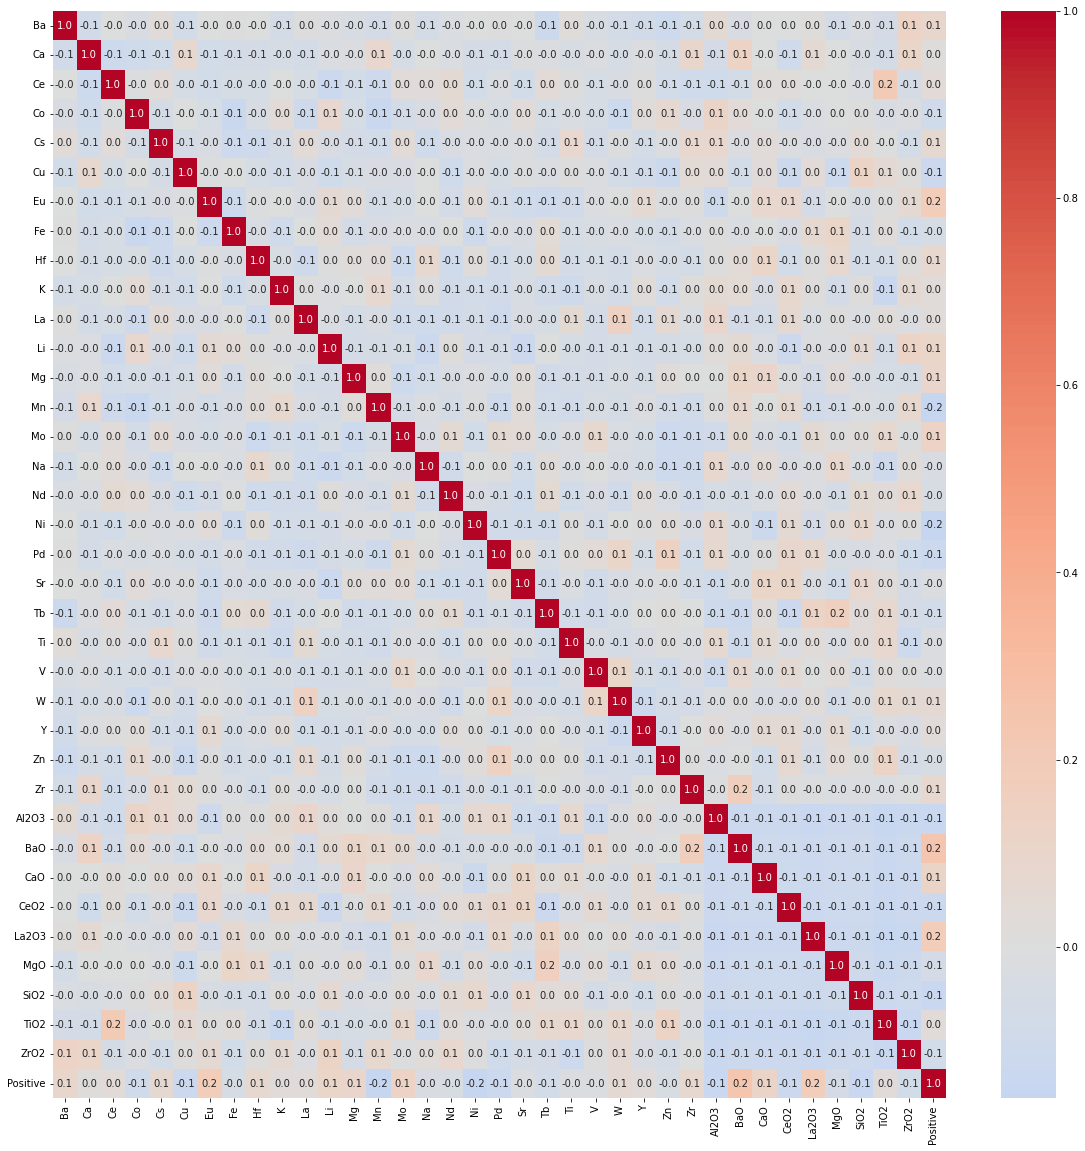

In [20]:
dataset.corr()
#plot the heatmap of the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(dataset.corr(), annot=True, fmt=".1f", cmap='coolwarm', center=0)

## Checking robustness of decision tree's performance metrics

In [5]:
n = 100
acc = []
f1 =[]

# training 100 different decision tree models on random training/test splits 
for rs in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs*1234+567)
    clf = DecisionTreeClassifier(random_state = rs).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))

# print(f'Accuracy scores: {acc}')
# print(f'F1 scores: {f1}')
print(f'Accuracy scores mean: {np.mean(acc)}')
print(f'Accuracy scores standard deviation: {np.std(acc)}')
print(f'F1 scores mean: {np.mean(f1)}')
print(f'F1 scores mean standard deviation: {np.std(f1)}')

Accuracy scores mean: 0.7662711864406779
Accuracy scores standard deviation: 0.0475963468961924
F1 scores mean: 0.34892201865564837
F1 scores mean standard deviation: 0.12265164180156819


In [27]:
# colors = ['#377eb8', '#ff7f00', '#4daf4a', '#984ea3']

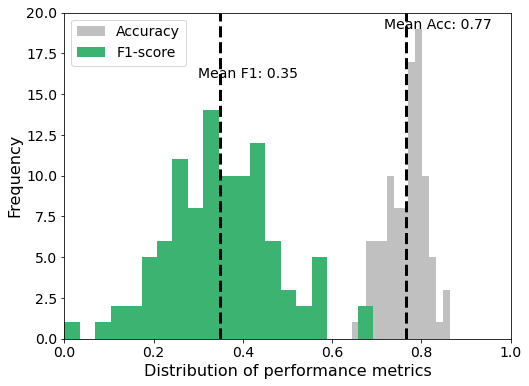

In [28]:
plt.figure(figsize=(8,6))
plt.axvline(np.mean(acc), color='black', linestyle='dashed', linewidth=3) # Mean of the distribution
plt.axvline(np.mean(f1), color='black', linestyle='dashed', linewidth=3)
plt.text(np.mean(acc) - 0.05, 19, f'Mean Acc: {np.mean(acc):.2f}', fontsize=14, color='black')
plt.text(np.mean(f1) - 0.05, 16, f'Mean F1: {np.mean(f1):.2f}', fontsize=14, color='black')
plt.hist(np.array(acc), bins = 14, color='#c0c0c0', label='Accuracy')
plt.hist(np.array(f1), bins = 20, color='#3cb371', label='F1-score')
plt.xticks(fontsize= 14) 
plt.yticks(fontsize= 14) 
plt.xlabel('Distribution of performance metrics',fontsize= 16)
plt.ylabel('Frequency',fontsize= 16)
plt.legend(fontsize= 14)
plt.xlim(0, 1)
plt.ylim(0, 20)
plt.savefig('figures/first_DT_accuracy_distribution_without_group.png')
plt.show()

### Stratified sampling

In the whole dataset, there are 51 positive catalysts and 240 non-positive catalysts. To avoid extremely unbalanced data in training set or testing set due to random split, we use stratified sampling to ensure the same proportion of postive catalysts in training set and testing set with the orignal data set.

In [29]:
dataset_pos = dataset.iloc[y==True,].values.astype('bool')
dataset_neg = dataset.iloc[y==False,].values.astype('bool')
X_pos = dataset_pos[:, 1:-1]
y_pos = dataset_pos[:, -1]
X_neg = dataset_neg[:, 1:-1]
y_neg = dataset_neg[:, -1]

In [30]:
def stratified_sampling (X_pos, X_neg, y_pos, y_neg, rs):
    X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, test_size = 0.2, random_state = rs)
    X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg, y_neg, test_size = 0.2, random_state = rs)
    X_train = np.concatenate((X_pos_train, X_neg_train), axis=0)
    y_train = np.concatenate((y_pos_train, y_neg_train), axis=0)
    X_test = np.concatenate((X_pos_test, X_neg_test), axis=0)
    y_test = np.concatenate((y_pos_test, y_neg_test), axis=0)
    return X_train, y_train, X_test, y_test

### Resampling

To further overcome the unbalanceness, we resample the training data set (size=232, Pos:Non_Pos = 41:191) through a combination of oversampling and undersampling. We first do oversampling using the most popular method SMOTE with a ratio of 0.6 = (232/2) : 191. This ratio refers to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling. We then do random undersampling with a ratio of 1 to ensure equal sample size of two classes.

In [31]:
# combine SMOTE and random undersampling
def resampling (X, y, overratio, underratio, randomstate):
    X = X.astype(int)
    y = y.astype(int)
    over = SMOTE(sampling_strategy=overratio, random_state=randomstate) # set this value to get similar sample size before and after resampling
    under = RandomUnderSampler(sampling_strategy=underratio, random_state=randomstate) # to get equal sample sizes of two classes
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)
    X = X.astype(bool)
    y = y.astype(bool)
    return X, y

In [32]:
# Double checking the resampling process, to find out how many new samples are generated
X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
original_indices = []
for x in X:
    result = np.where(np.all(X_train == x, axis=1))
    if result[0].size > 0:
        original_indices.append(result[0][0])

original_indices = np.unique(original_indices)

# Output results
if len(original_indices) == len(X):
    print("All original samples are in the resampled dataset")
else:
    num_new_samples = len(X_train) - len(original_indices)
    print(f"There are {num_new_samples} new, synthetically generated samples in the resampled dataset")


There are 75 new, synthetically generated samples in the resampled dataset


### Decision tree

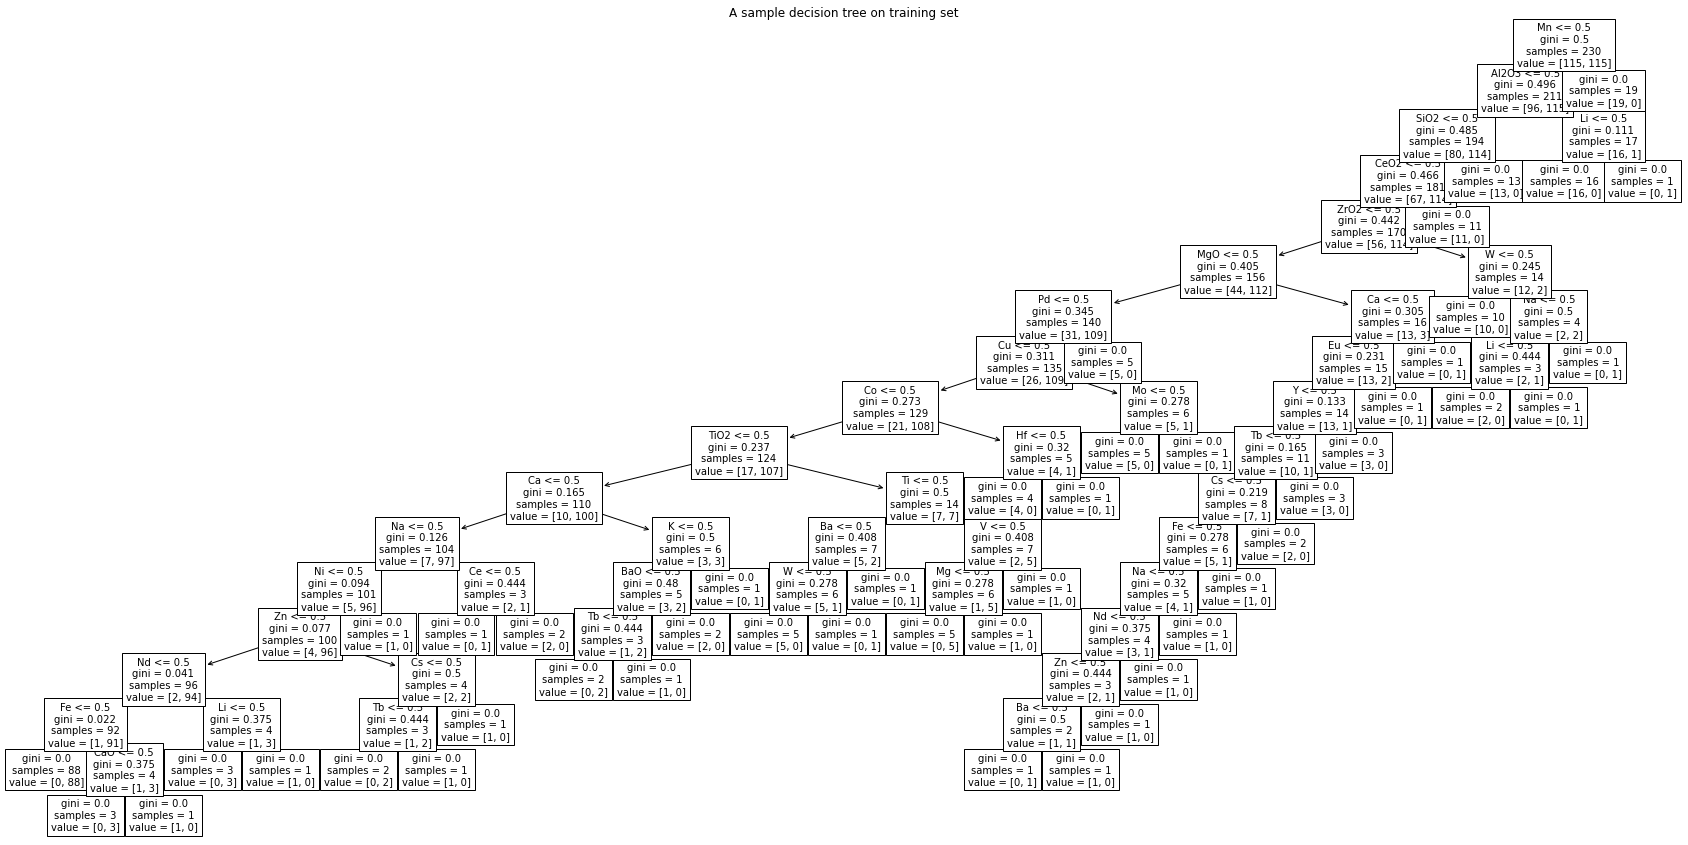

In [33]:
# In  this Decision Tree, there are n iterations, each iteration has a different random state. The random state of Decision Tree is fixed to 0, for the purpose of comparison.

n = 100

# Initialize lists to store evaluation metrics
acc_tree = []
precision_tree = []
recall_tree = []
f1_tree = []

# Initialize a list to store feature importance values for each split
feature_importances_tree = []

for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)

    clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate evaluation metrics and store them
    acc_tree.append(accuracy_score(y_test, y_pred))
    precision_tree.append(precision_score(y_test, y_pred, zero_division=1))
    recall_tree.append(recall_score(y_test, y_pred))
    f1_tree.append(f1_score(y_test, y_pred))
    
    # Store feature importance for this split
    feature_importances_tree.append(clf.feature_importances_)

    # Show an example tree for a specific iteration (e.g., 50th iteration)
    if rs == 50:
        plt.figure(figsize=(30, 15))
        plot_tree(clf, filled=False, fontsize=10, feature_names=feature_names)
        plt.title("A sample decision tree on training set")
        plt.show()

In [34]:
df_metrics = get_formatted_results(acc_tree, f1_tree, precision_tree, recall_tree, model_name="Decision Tree", verbose=True, df_metrics = None)

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.753898 │            0.0522122 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.45702  │            0.0985697 │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.395042 │            0.0892192 │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.56     │            0.147553  │
╘═══════════╧══════════╧══════════════════════╛


In [35]:
df_metrics

,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.45702,0.09857,0.395042,0.089219,0.56,0.147553


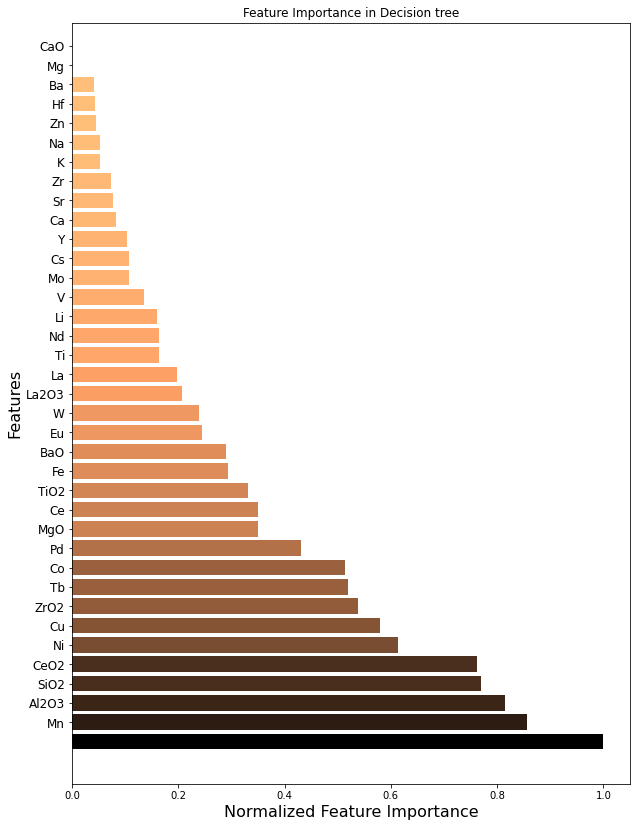

,Feature,Decision tree
0,Ba,0.043448
1,Ca,0.104177
2,Ce,0.349826
3,Co,0.519474
4,Cs,0.107886
5,Cu,0.613454
6,Eu,0.289563
7,Fe,0.330453
8,Hf,0.045049
9,K,0.074084


In [36]:
df_feature_importance = plot_feature_importance(feature_importances_tree, feature_names, model_name="Decision tree", df_feature_importance=None)
df_feature_importance

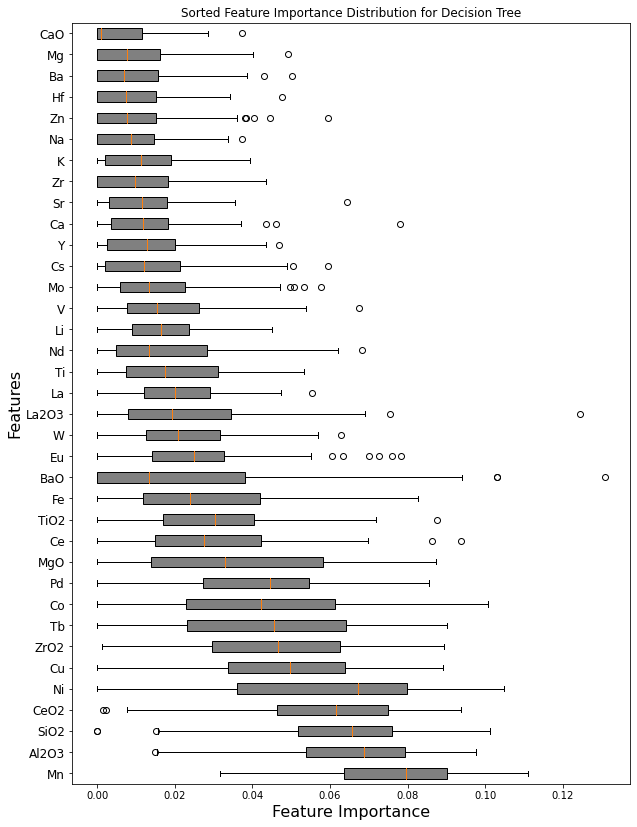

In [37]:
plot_feature_importance_distribution(feature_importances_tree, feature_names, "Decision Tree", color='gray')

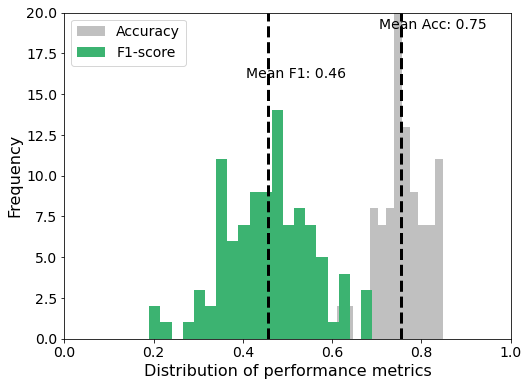

In [38]:
plt.figure(figsize=(8,6))
plt.axvline(np.mean(acc_tree), color='black', linestyle='dashed', linewidth=3)
plt.axvline(np.mean(f1_tree), color='black', linestyle='dashed', linewidth=3)
plt.text(np.mean(acc_tree) - 0.05, 19, f'Mean Acc: {np.mean(acc_tree):.2f}', fontsize=14, color='black')
plt.text(np.mean(f1_tree) - 0.05, 16, f'Mean F1: {np.mean(f1_tree):.2f}', fontsize=14, color='black')

plt.hist(np.array(acc_tree), bins = 14, color='#c0c0c0', label='Accuracy')
plt.hist(np.array(f1_tree), bins = 20, color='#3cb371', label='F1-score')
plt.xticks(fontsize= 14) 
plt.yticks(fontsize= 14) 
plt.xlabel('Distribution of performance metrics',fontsize= 16)
plt.ylabel('Frequency',fontsize= 16)
plt.legend(fontsize= 14)
plt.xlim(0, 1)
plt.ylim(0, 20)
plt.savefig('/Users/parastoo/phd_projects/OCM/plots/pipeline_DT_accuracy_distribution_without_group.png', dpi=300)

## Decision Tree without RESAMPLING

In [40]:
n = 100

# Initialize lists to store evaluation metrics
acc_tree_nr = []
precision_tree_nr = []
recall_tree_nr = []
f1_tree_nr = []
feature_importances_tree_nr = []

for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)

    clf_nr = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
    y_pred_nr = clf_nr.predict(X_test)
    
    # Calculate evaluation metrics and store them
    acc_tree_nr.append(accuracy_score(y_test, y_pred_nr))
    precision_tree_nr.append(precision_score(y_test, y_pred_nr, zero_division=1))
    recall_tree_nr.append(recall_score(y_test, y_pred_nr))
    f1_tree_nr.append(f1_score(y_test, y_pred_nr))
    
    # Store feature importance for this split
    feature_importances_tree_nr.append(clf_nr.feature_importances_)


# EVALUATION METRICS
# Calculate mean and standard deviation of evaluation metrics
mean_acc_tree_nr = np.mean(acc_tree_nr)
std_acc_tree_nr = np.std(acc_tree_nr)
mean_f1_tree_nr = np.mean(f1_tree_nr)
std_f1_tree_nr = np.std(f1_tree_nr)
mean_precision_tree_nr = np.mean(precision_tree_nr)
std_precision_tree_nr = np.std(precision_tree_nr)
mean_recall_tree_nr = np.mean(recall_tree_nr)
std_recall_tree_nr = np.std(recall_tree_nr)

# Create a list of tuples for the table
table_data_nr = [
    ('Metric', 'Mean', 'Standard Deviation'),
    ('Accuracy', mean_acc_tree_nr, std_acc_tree_nr),
    ('F1 Score', mean_f1_tree_nr, std_f1_tree_nr),
    ('Precision', mean_precision_tree_nr, std_precision_tree_nr),
    ('Recall', mean_recall_tree_nr, std_recall_tree_nr)
]

# Print the table
print(tabulate(table_data_nr, headers='firstrow', tablefmt='fancy_grid'))

# Create a dictionary with the data
data_nr = {
    'Model': ['Decision Tree'],
    'Accuracy_Mean': [mean_acc_tree_nr],
    'Accuracy_Std': [std_acc_tree_nr],
    'F1_Mean': [mean_f1_tree_nr],
    'F1_Std': [std_f1_tree_nr],
    'Precision_Mean': [mean_precision_tree_nr],
    'Precision_Std': [std_precision_tree_nr],
    'Recall_Mean': [mean_recall_tree_nr],
    'Recall_Std': [std_recall_tree_nr]
}

# Create the DataFrame
df_metrics_nr = pd.DataFrame(data_nr)

# Display the DataFrame
print(df_metrics_nr)


╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.764915 │            0.0444349 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.369698 │            0.109174  │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.376323 │            0.115006  │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.375455 │            0.128985  │
╘═══════════╧══════════╧══════════════════════╛
           Model  Accuracy_Mean  Accuracy_Std   F1_Mean    F1_Std  \
0  Decision Tree       0.764915      0.044435  0.369698  0.109174   

   Precision_Mean  Precision_Std  Recall_Mean  Recall_Std  
0        0.376323       0.115006     0.375455    0.128985  


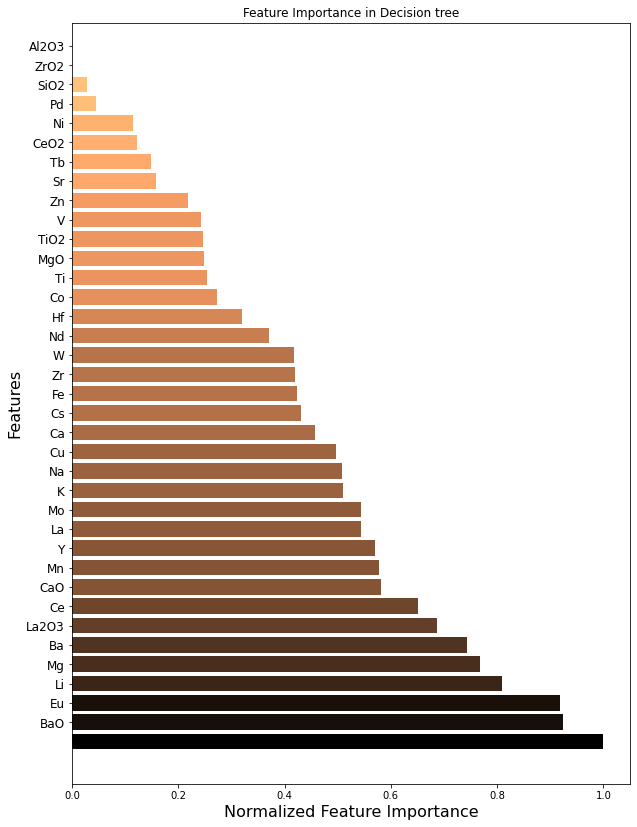

,Feature,Decision tree
0,Ba,0.768629
1,Ca,0.496448
2,Ce,0.687321
3,Co,0.320590
4,Cs,0.457643
5,Cu,0.507390
6,Eu,0.923366
7,Fe,0.431689
8,Hf,0.370218
9,K,0.543470


In [41]:
df_feature_importance_nr = plot_feature_importance(feature_importances_tree_nr, feature_names, model_name="Decision tree", df_feature_importance=None)
df_feature_importance_nr

## DT with Pre-Pruning

Split 0


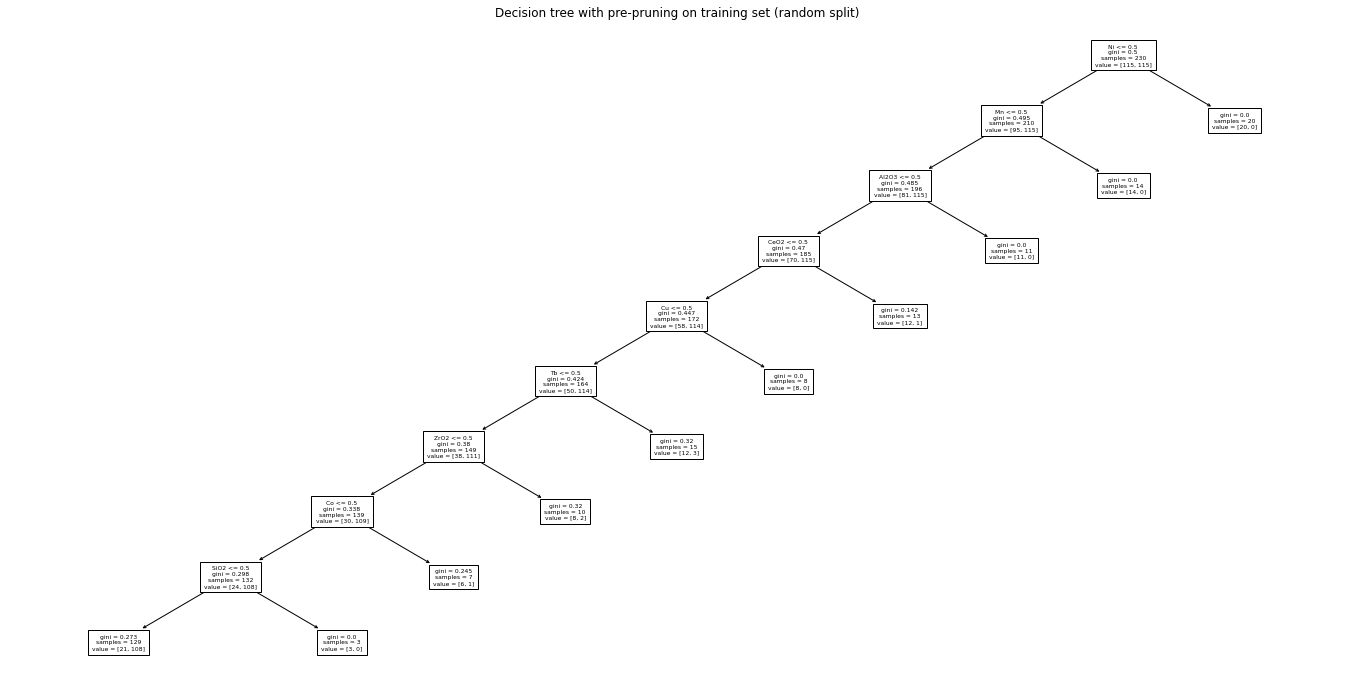

Split 10
Split 20
Split 30
Split 40
Split 50
Split 60
Split 70
Split 80
Split 90


In [43]:
n = 100
acc_preprun = []
precision_preprun = []
recall_preprun = []
f1_preprun = []
max_depth_preprun = []
min_samples_split_preprun = []
min_samples_leaf_preprun = []

# Initialize a list to store feature importance values for each split
feature_importances_preprun = []

# Define the objective function for optimization
def objective(params):
    max_depth, min_samples_split, min_samples_leaf = params
    clf_preprun = DecisionTreeClassifier(
        random_state=0, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    return -np.mean(cross_val_score(clf_preprun, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))

for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)

    space = [
        Integer(1, 10, name='max_depth'),
        Integer(2, 20, name='min_samples_split'),
        Integer(1, 20, name='min_samples_leaf')
    ]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res_gp = gp_minimize(objective, space, n_calls=30, random_state=0, n_initial_points=10)

    clf_preprun_optim = DecisionTreeClassifier(
        random_state=0, 
        max_depth=res_gp.x[0], 
        min_samples_split=res_gp.x[1], 
        min_samples_leaf=res_gp.x[2]
    )
    max_depth_preprun.append(res_gp.x[0])
    min_samples_split_preprun.append(res_gp.x[1])
    min_samples_leaf_preprun.append(res_gp.x[2])

    clf_preprun_optim.fit(X_train, y_train)
    y_pred = clf_preprun_optim.predict(X_test)

    acc_preprun.append(accuracy_score(y_test, y_pred))
    precision_preprun.append(precision_score(y_test, y_pred, zero_division=1))
    recall_preprun.append(recall_score(y_test, y_pred))
    f1_preprun.append(f1_score(y_test, y_pred)) 
    
    # Store feature importance for this split
    feature_importances_preprun.append(clf_preprun_optim.feature_importances_)

    if rs % 10 == 0:
        print("Split %s" % rs)
    # Show an example tree
    if rs == 1:
        plt.figure(figsize=(24, 12))
        plot_tree(clf_preprun_optim, filled=False, fontsize=6, feature_names=feature_names)
        plt.title("Decision tree with pre-pruning on training set (random split)")
        plt.show()



In [44]:
df_metrics = get_formatted_results(acc_preprun, f1_preprun, precision_preprun, recall_preprun, model_name="DT prepruned", verbose=True, df_metrics=df_metrics)
df_metrics

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.730339 │            0.0631499 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.475768 │            0.0830662 │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.381914 │            0.0747489 │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.656364 │            0.155122  │
╘═══════════╧══════════╧══════════════════════╛


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.457020,0.098570,0.395042,0.089219,0.560000,0.147553
1,DT prepruned,0.730339,0.063150,0.475768,0.083066,0.381914,0.074749,0.656364,0.155122


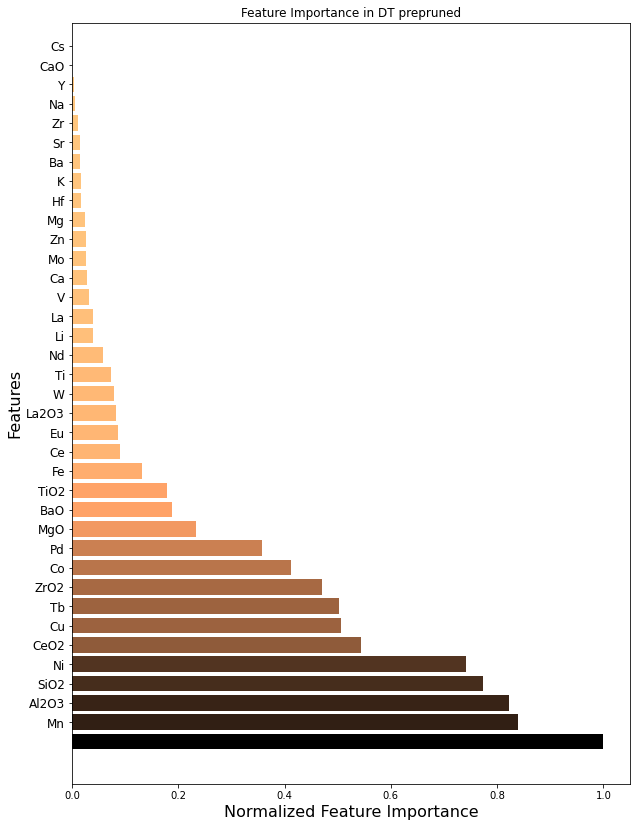

,Feature,Decision tree,DT prepruned
0,Ba,0.043448,0.016782
1,Ca,0.104177,0.032347
2,Ce,0.349826,0.131717
3,Co,0.519474,0.470619
4,Cs,0.107886,0.000000
5,Cu,0.613454,0.543786
6,Eu,0.289563,0.090879
7,Fe,0.330453,0.179699
8,Hf,0.045049,0.023900
9,K,0.074084,0.017214


In [45]:
df_feature_importance = plot_feature_importance(feature_importances_preprun, feature_names, model_name="DT prepruned", df_feature_importance=df_feature_importance)
df_feature_importance

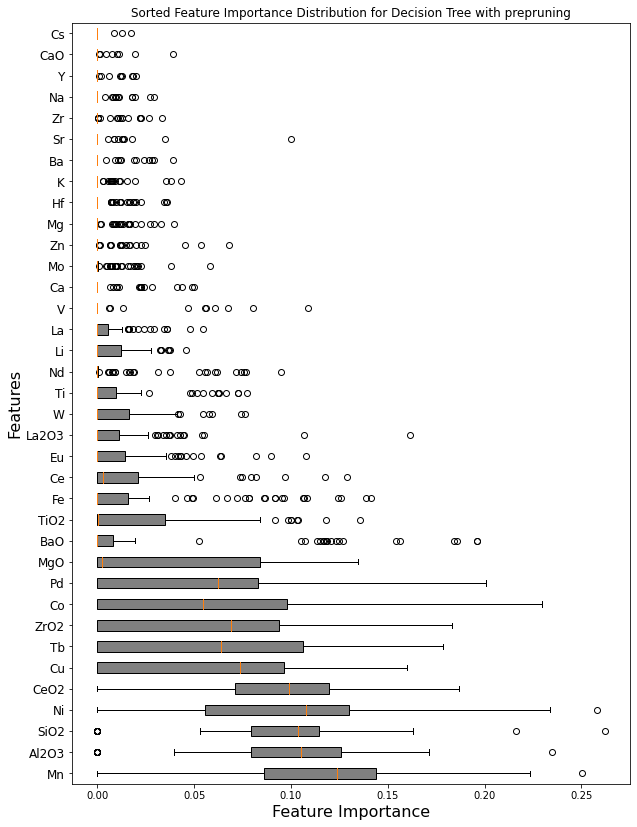

In [46]:
plot_feature_importance_distribution(feature_importances_preprun, feature_names, "Decision Tree with prepruning", color='gray')

## PrePrun without Resampling

In [49]:
 n = 100

# Initialize lists to store evaluation metrics
acc_preprun_nr = []
precision_preprun_nr = []
recall_preprun_nr = []
f1_preprun_nr = []
max_depth_preprun_nr = []
min_samples_split_preprun_nr = []
min_samples_leaf_preprun_nr = []

# Initialize a list to store feature importance values for each split
feature_importances_preprun_nr = []

# Define the objective function for optimization
def objective(params):
    max_depth, min_samples_split, min_samples_leaf = params
    clf_preprun_nr = DecisionTreeClassifier(
        random_state=0, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    return -np.mean(cross_val_score(clf_preprun_nr, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))

for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)

    space = [
        Integer(1, 10, name='max_depth'),
        Integer(2, 20, name='min_samples_split'),
        Integer(1, 20, name='min_samples_leaf')
    ]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res_gp = gp_minimize(objective, space, n_calls=30, random_state=0, n_initial_points=10)

    clf_preprun_optim_nr = DecisionTreeClassifier(
        random_state=0, 
        max_depth=res_gp.x[0], 
        min_samples_split=res_gp.x[1], 
        min_samples_leaf=res_gp.x[2]
    )
    max_depth_preprun_nr.append(res_gp.x[0])
    min_samples_split_preprun_nr.append(res_gp.x[1])
    min_samples_leaf_preprun_nr.append(res_gp.x[2])

    clf_preprun_optim_nr.fit(X_train, y_train)
    y_pred_nr = clf_preprun_optim_nr.predict(X_test)

    acc_preprun_nr.append(accuracy_score(y_test, y_pred_nr))
    precision_preprun_nr.append(precision_score(y_test, y_pred_nr, zero_division=1))
    recall_preprun_nr.append(recall_score(y_test, y_pred_nr))
    f1_preprun_nr.append(f1_score(y_test, y_pred_nr)) 
    
    # Store feature importance for this split
    feature_importances_preprun_nr.append(clf_preprun_optim_nr.feature_importances_)
    if rs % 25 == 0:
        print("Split %s" % rs)




Split 0


In [ ]:
df_metrics_nr = get_formatted_results(acc_preprun_nr, f1_preprun_nr, precision_preprun_nr, recall_preprun_nr, model_name="DT prepruned", verbose=True, df_metrics = df_metrics_nr)
df_metrics_nr

NameError: name 'acc_preprun_nr' is not defined

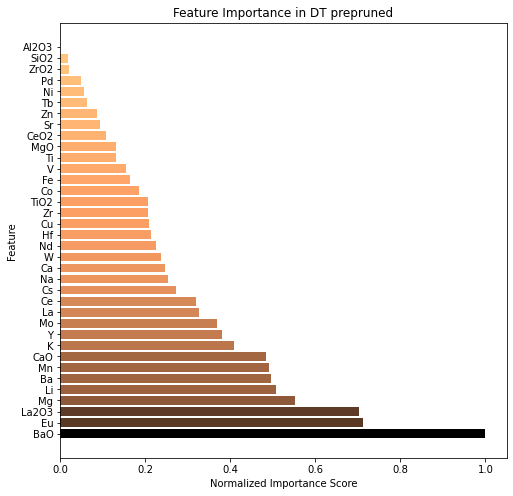

,Feature,Decision tree,DT prepruned
0,Ba,0.768629,0.495894
1,Ca,0.496448,0.247061
2,Ce,0.687321,0.319966
3,Co,0.320590,0.185704
4,Cs,0.457643,0.272984
5,Cu,0.507390,0.209335
6,Eu,0.923366,0.711945
7,Fe,0.431689,0.163559
8,Hf,0.370218,0.212451
9,K,0.543470,0.407533


In [ ]:
df_feature_importance_nr = plot_feature_importance(feature_importances_preprun_nr, feature_names, model_name="DT prepruned", df_feature_importance=df_feature_importance_nr)
df_feature_importance_nr

## Decision tree with post-pruning

Split 0


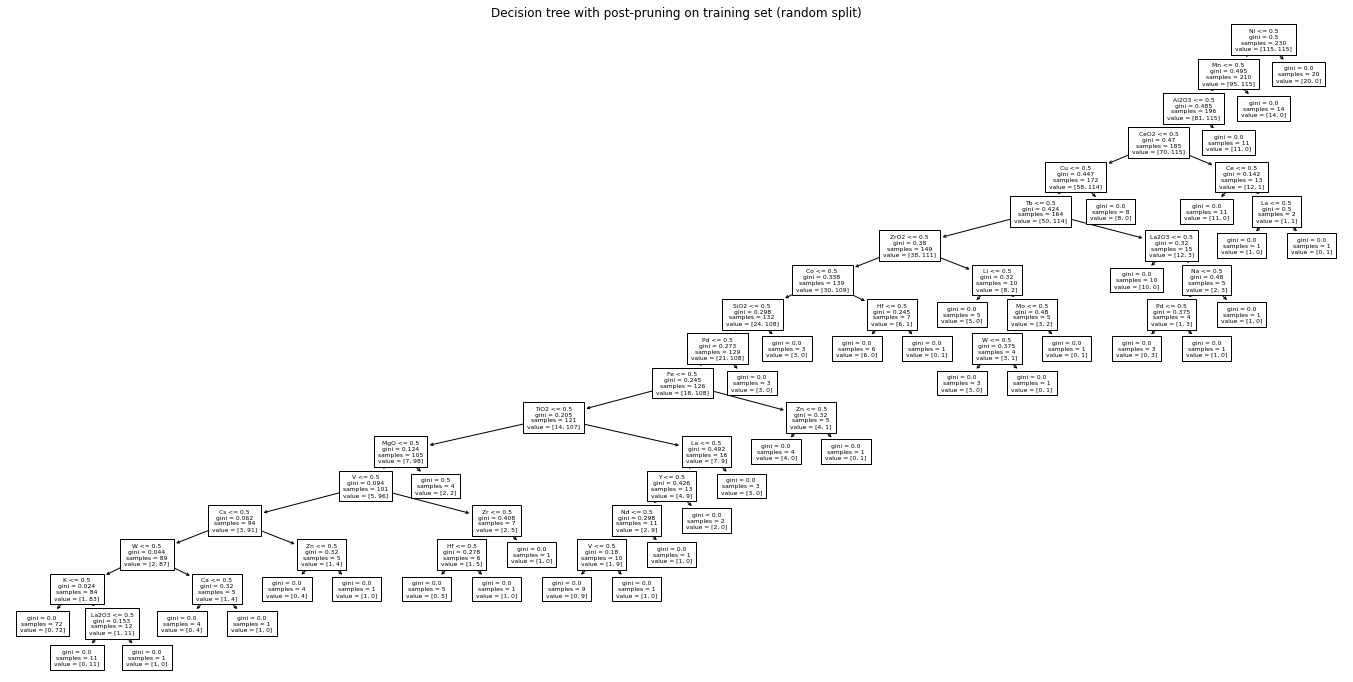

Split 50


In [ ]:
n = 100
acc_postprun = []
precision_postprun = []
recall_postprun = []
f1_postprun =[]
alpha_postprun =[]
feature_importances_postprun = []

for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)

    clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    clfs_ = []
    for ccp_alpha in ccp_alphas:
        clf_ = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf_.fit(X_train, y_train)
        clfs_.append(clf_)

    clfs_ = clfs_[:-1]
    ccp_alphas = ccp_alphas[:-1]

    train_acc = []
    test_acc = []
    for c in clfs_:
        y_train_pred = c.predict(X_train)
        y_test_pred = c.predict(X_test)
        train_acc.append(accuracy_score(y_train, y_train_pred))
        test_acc.append(accuracy_score(y_test, y_test_pred))

    alpha = ccp_alphas[np.argmax(test_acc)]
    alpha_postprun.append(alpha)
    clf_postprun = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    clf_postprun.fit(X_train, y_train)
    y_pred_postprun = clf_postprun.predict(X_test)

    acc_postprun.append(accuracy_score(y_test, y_pred_postprun))
    precision_postprun.append(precision_score(y_test, y_pred_postprun, zero_division=1))
    recall_postprun.append(recall_score(y_test, y_pred_postprun))
    f1_postprun.append(f1_score(y_test, y_pred_postprun))

    # Store feature importance for this split
    feature_importances_postprun.append(clf_postprun.feature_importances_)

    if rs % 50 == 0:
        print("Split %s" % rs)

    # Show an example tree
    if rs == 1:
        plt.figure(figsize=(24, 12))
        plot_tree(clf_postprun, filled=False, fontsize=6, feature_names=feature_names)
        plt.title("Decision tree with post-pruning on training set (random split)")
        plt.show()



In [ ]:
df_metrics = get_formatted_results(acc_postprun, f1_postprun, precision_postprun, recall_postprun, model_name="DT postpruned", verbose=True, df_metrics=df_metrics)
df_metrics 

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.808983 │            0.0423969 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.500634 │            0.131402  │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.493784 │            0.106958  │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.538182 │            0.182127  │
╘═══════════╧══════════╧══════════════════════╛


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.457020,0.098570,0.395042,0.089219,0.560000,0.147553
1,DT prepruned,0.730339,0.063150,0.475768,0.083066,0.381914,0.074749,0.656364,0.155122
2,DT postpruned,0.808983,0.042397,0.500634,0.131402,0.493784,0.106958,0.538182,0.182127


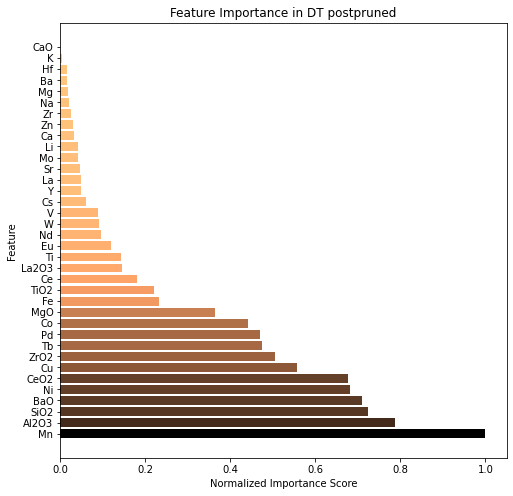

,Feature,Decision tree,DT prepruned,DT postpruned
0,Ba,0.043448,0.016782,0.015632
1,Ca,0.104177,0.032347,0.032414
2,Ce,0.349826,0.131717,0.179657
3,Co,0.519474,0.470619,0.442338
4,Cs,0.107886,0.000000,0.059824
5,Cu,0.613454,0.543786,0.555956
6,Eu,0.289563,0.090879,0.119971
7,Fe,0.330453,0.179699,0.230992
8,Hf,0.045049,0.023900,0.015546
9,K,0.074084,0.017214,0.003937


In [ ]:
df_feature_importance = plot_feature_importance(feature_importances_postprun, feature_names, model_name="DT postpruned", df_feature_importance=df_feature_importance)
df_feature_importance

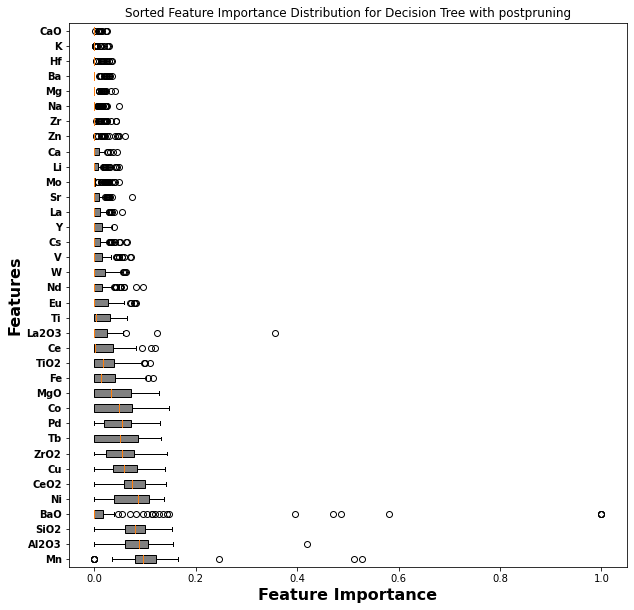

In [ ]:
plot_feature_importance_distribution(feature_importances_postprun, feature_names, "Decision Tree with postpruning", color='gray')

In [ ]:
df_melted = pd.melt(df_feature_importance, id_vars='Feature', var_name='Model', value_name='Importance')

# Create a grouped bar plot using Plotly Express
fig = px.bar(df_melted, x='Feature', y='Importance', color='Model',
             labels={'Importance': 'Feature Importance', 'Model': 'Model'},
             title='Feature Importance Comparison',
             barmode='group'  # Set barmode to 'group' for grouped bars
            )  # Set the width of the bars

# Adjust the width of the bars in the layout
fig.update_layout(bargap=0.3, bargroupgap=0.3)


# Show the plot
fig.show()

## Postprune without Resampling

In [ ]:
# Set the number of iterations
n = 100

# Initialize lists for metrics and feature importances
acc_postprun_nr = []
precision_postprun_nr = []
recall_postprun_nr = []
f1_postprun_nr = []
alpha_postprun_nr = []
feature_importances_postprun_nr = []

# Loop through iterations
for rs in range(n):
    # Stratified sampling without resampling
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    
    # Decision tree without resampling
    clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
    
    # Cost complexity pruning
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    clfs_ = [tree.DecisionTreeClassifier(random_state=0, ccp_alpha=alpha).fit(X_train, y_train) for alpha in ccp_alphas[:-1]]

    # Calculate accuracies for different alphas
    train_acc = [accuracy_score(y_train, clf.predict(X_train)) for clf in clfs_]
    test_acc = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs_]
    
    # Select the alpha with the highest test accuracy
    alpha = ccp_alphas[np.argmax(test_acc)]
    alpha_postprun_nr.append(alpha)
    
    # Fit a decision tree with the selected alpha
    clf_postprun = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=alpha).fit(X_train, y_train)
    y_pred_postprun = clf_postprun.predict(X_test)

    # Calculate evaluation metrics and store them
    acc_postprun_nr.append(accuracy_score(y_test, y_pred_postprun))
    precision_postprun_nr.append(precision_score(y_test, y_pred_postprun, zero_division=1))
    recall_postprun_nr.append(recall_score(y_test, y_pred_postprun))
    f1_postprun_nr.append(f1_score(y_test, y_pred_postprun))

    # Store feature importance for this split
    feature_importances_postprun_nr.append(clf_postprun.feature_importances_)

    if rs % 25 == 0:
        print("Split %s" % rs)


Split 0
Split 25
Split 50
Split 75


In [ ]:
df_metrics_nr = get_formatted_results(acc_postprun_nr, f1_postprun_nr, precision_postprun_nr, recall_postprun_nr, model_name="DT postpruned", verbose=True, df_metrics = df_metrics_nr)


╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.827458 │            0.0229133 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.318314 │            0.191723  │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.697324 │            0.216694  │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.255455 │            0.178929  │
╘═══════════╧══════════╧══════════════════════╛


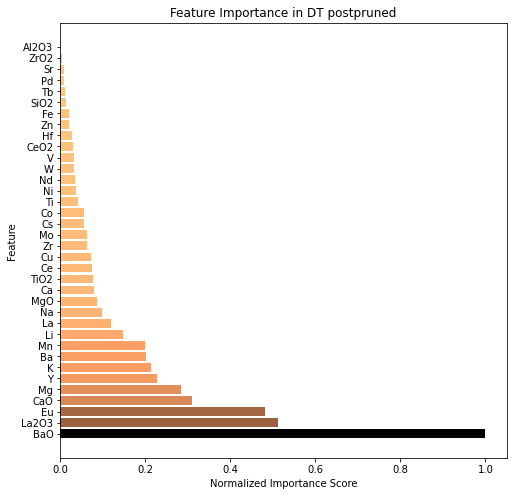

,Feature,Decision tree,DT prepruned,DT postpruned
0,Ba,0.768629,0.495894,0.201020
1,Ca,0.496448,0.247061,0.080003
2,Ce,0.687321,0.319966,0.073332
3,Co,0.320590,0.185704,0.054516
4,Cs,0.457643,0.272984,0.056815
5,Cu,0.507390,0.209335,0.072497
6,Eu,0.923366,0.711945,0.481774
7,Fe,0.431689,0.163559,0.021093
8,Hf,0.370218,0.212451,0.026448
9,K,0.543470,0.407533,0.214106


In [ ]:
df_feature_importance_nr = plot_feature_importance(feature_importances_postprun_nr, feature_names, model_name="DT postpruned", df_feature_importance=df_feature_importance_nr)
df_feature_importance_nr

In [ ]:
df_melted_nr = pd.melt(df_feature_importance_nr, id_vars='Feature', var_name='Model', value_name='Importance')

# Create a grouped bar plot using Plotly Express
fig = px.bar(df_melted_nr, x='Feature', y='Importance', color='Model',
             labels={'Importance': 'Feature Importance', 'Model': 'Model'},
             title='Feature Importance Comparison without Resampling',
             barmode='group'  # Set barmode to 'group' for grouped bars
            )  # Set the width of the bars

# Adjust the width of the bars in the layout
fig.update_layout(bargap=0.3, bargroupgap=0.3)


# Show the plot
fig.show()

### Random forest

In [ ]:
n = 100
acc_forest = []
precision_forest = []
recall_forest = []
f1_forest = []
max_depth_rf = []
n_estimators_rf = []
min_samples_split_rf = []
min_samples_leaf_rf = []
feature_importances_forest = []

# Loop through different random splits
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)

    clf_forest = RandomForestClassifier(random_state=0)
    space = [Integer(1, 10, name='max_depth'),
             Integer(50, 500, name='n_estimators'),
             Integer(2, 20, name='min_samples_split'),
             Integer(1, 20, name='min_samples_leaf')]
    
    @use_named_args(space)
    def objective(**params):
        clf_forest.set_params(**params)
        return -np.mean(cross_val_score(clf_forest, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))

    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    
    clf_forest_optim = RandomForestClassifier(random_state=0, max_depth=res_gp.x[0], n_estimators=res_gp.x[1],
                                              min_samples_split=res_gp.x[2], min_samples_leaf=res_gp.x[3])
    
    max_depth_rf.append(res_gp.x[0])
    n_estimators_rf.append(res_gp.x[1])
    min_samples_split_rf.append(res_gp.x[2])
    min_samples_leaf_rf.append(res_gp.x[3])

    clf_forest_optim.fit(X_train, y_train)
    y_pred = clf_forest_optim.predict(X_test)

    # Store feature importance for this split
    feature_importances_forest.append(clf_forest_optim.feature_importances_)

    acc_forest.append(accuracy_score(y_test, y_pred))
    precision_forest.append(precision_score(y_test, y_pred, zero_division=1))
    recall_forest.append(recall_score(y_test, y_pred))
    f1_forest.append(f1_score(y_test, y_pred))

    if rs % 25 == 0:
        print("Split %s" % rs)

Split 0
Split 25
Split 50
Split 75


In [ ]:
df_metrics = get_formatted_results(acc_forest, f1_forest, precision_forest, recall_forest, model_name="Random forest", verbose=True, df_metrics=df_metrics)
df_metrics

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.780678 │            0.0499825 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.516662 │            0.0902825 │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.448324 │            0.0872944 │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.631818 │            0.146798  │
╘═══════════╧══════════╧══════════════════════╛


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.457020,0.098570,0.395042,0.089219,0.560000,0.147553
1,DT prepruned,0.730339,0.063150,0.475768,0.083066,0.381914,0.074749,0.656364,0.155122
2,DT postpruned,0.808983,0.042397,0.500634,0.131402,0.493784,0.106958,0.538182,0.182127
3,Random forest,0.780678,0.049982,0.516662,0.090282,0.448324,0.087294,0.631818,0.146798


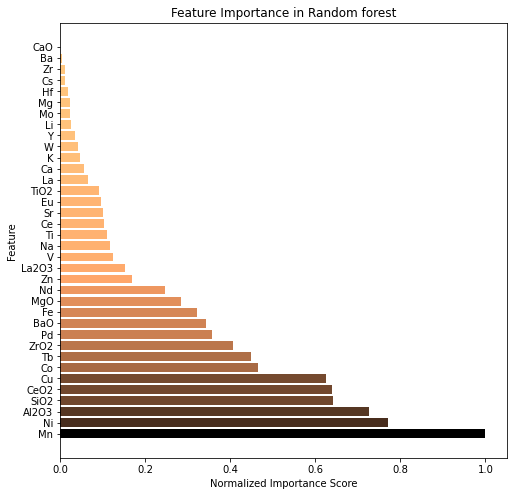

In [ ]:
df_feature_importance = plot_feature_importance(feature_importances_forest, feature_names, model_name="Random forest", df_feature_importance=df_feature_importance)

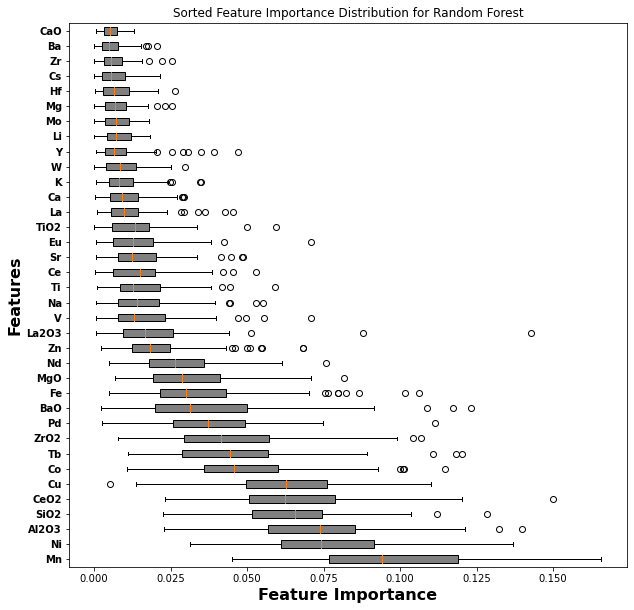

In [ ]:
plot_feature_importance_distribution(feature_importances_forest, feature_names, "Random Forest", color='gray')

## Random Forest without Resampling

In [ ]:
# WITH DISTRIBUTION OF feature importance without resampling
n = 100
acc_forest_nr = []
precision_forest_nr = []
recall_forest_nr = []
f1_forest_nr = []
max_depth_rf_nr = []
n_estimators_rf_nr = []
min_samples_split_rf_nr = []
min_samples_leaf_rf_nr = []
feature_importances_forest_nr = []

# Loop through different random splits
for rs in range(n):
    # Stratified sampling without resampling
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    
    clf_forest = RandomForestClassifier(random_state=0)
    space = [Integer(1, 10, name='max_depth'),
             Integer(50, 500, name='n_estimators'),
             Integer(2, 20, name='min_samples_split'),
             Integer(1, 20, name='min_samples_leaf')]
    
    @use_named_args(space)
    def objective(**params):
        clf_forest.set_params(**params)
        return -np.mean(cross_val_score(clf_forest, X_train, y_train, cv=5, n_jobs=8, scoring="f1"))

    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    
    clf_forest_optim = RandomForestClassifier(random_state=0, max_depth=res_gp.x[0], n_estimators=res_gp.x[1],
                                              min_samples_split=res_gp.x[2], min_samples_leaf=res_gp.x[3])
    
    max_depth_rf_nr.append(res_gp.x[0])
    n_estimators_rf_nr.append(res_gp.x[1])
    min_samples_split_rf_nr.append(res_gp.x[2])
    min_samples_leaf_rf_nr.append(res_gp.x[3])

    clf_forest_optim.fit(X_train, y_train)
    y_pred = clf_forest_optim.predict(X_test)

    # Store feature importance for this split
    feature_importances_forest_nr.append(clf_forest_optim.feature_importances_)

    acc_forest_nr.append(accuracy_score(y_test, y_pred))
    precision_forest_nr.append(precision_score(y_test, y_pred, zero_division=1))
    recall_forest_nr.append(recall_score(y_test, y_pred))
    f1_forest_nr.append(f1_score(y_test, y_pred))



In [ ]:
df_metrics_nr = get_formatted_results(acc_forest_nr, f1_forest_nr, precision_forest_nr, recall_forest_nr, model_name="Random forest", verbose=True, df_metrics = df_metrics_nr)

╒═══════════╤═══════════╤══════════════════════╕
│ Metric    │      Mean │   Standard Deviation │
╞═══════════╪═══════════╪══════════════════════╡
│ Accuracy  │ 0.812203  │            0.021126  │
├───────────┼───────────┼──────────────────────┤
│ F1 Score  │ 0.100531  │            0.116892  │
├───────────┼───────────┼──────────────────────┤
│ Precision │ 0.644595  │            0.414472  │
├───────────┼───────────┼──────────────────────┤
│ Recall    │ 0.0609091 │            0.0727897 │
╘═══════════╧═══════════╧══════════════════════╛


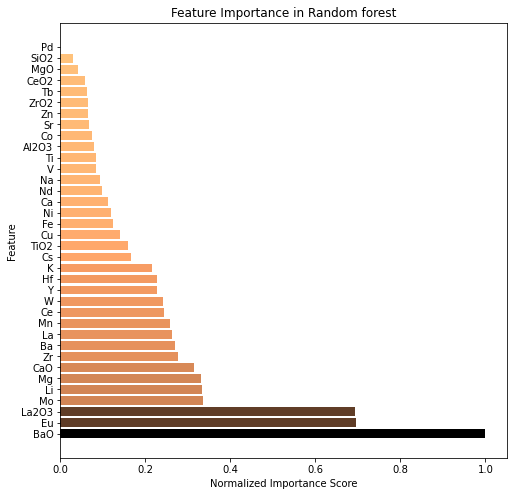

,Feature,Decision tree,DT prepruned,DT postpruned,Random forest
0,Ba,0.768629,0.495894,0.201020,0.269886
1,Ca,0.496448,0.247061,0.080003,0.112287
2,Ce,0.687321,0.319966,0.073332,0.244895
3,Co,0.320590,0.185704,0.054516,0.074888
4,Cs,0.457643,0.272984,0.056815,0.165847
5,Cu,0.507390,0.209335,0.072497,0.141010
6,Eu,0.923366,0.711945,0.481774,0.696226
7,Fe,0.431689,0.163559,0.021093,0.124530
8,Hf,0.370218,0.212451,0.026448,0.226595
9,K,0.543470,0.407533,0.214106,0.216707


In [ ]:
df_feature_importance_nr = plot_feature_importance(feature_importances_forest_nr, feature_names, model_name="Random forest", df_feature_importance=df_feature_importance_nr)
df_feature_importance_nr

### XGBoost

In [ ]:
n = 100
acc_XGBT = []
precision_XGBT = []
recall_XGBT = []
f1_XGBT = []
learning_rate_XGBT = []
n_estimators_XGBT = []
reg_alphas_XGBT = []
reg_lambdas_XGBT = []
feature_importances_XGBT = []

# Loop through different random splits
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)

    clf_XGBT = xgb.XGBClassifier(random_state=0)
    space = [Integer(1, 10, name='max_depth'),
             Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
             Real(10**-5, 10**0, "log-uniform", name='reg_alpha'),
             Real(10**-5, 10**0, "log-uniform", name='reg_lambda'),
             Integer(50, 500, name='n_estimators')]
    
    @use_named_args(space)
    def objective(**params):
        clf_XGBT.set_params(**params)
        return -np.mean(cross_val_score(clf_XGBT, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    
    clf_XGBT_optim = xgb.XGBClassifier(random_state=0, max_depth=res_gp.x[0], learning_rate=res_gp.x[1],
                                       reg_alpha=res_gp.x[2], reg_lambda=res_gp.x[3], n_estimators=res_gp.x[4])
    
    learning_rate_XGBT.append(res_gp.x[1])
    n_estimators_XGBT.append(res_gp.x[4])
    reg_alphas_XGBT.append(res_gp.x[2])
    reg_lambdas_XGBT.append(res_gp.x[3])
    
    clf_XGBT_optim.fit(X_train, y_train)
    y_pred = clf_XGBT_optim.predict(X_test)
    
    acc_XGBT.append(accuracy_score(y_test, y_pred))
    precision_XGBT.append(precision_score(y_test, y_pred, zero_division=1))
    recall_XGBT.append(recall_score(y_test, y_pred))
    f1_XGBT.append(f1_score(y_test, y_pred))
    
    # Save feature importances for this split
    feature_importances_XGBT.append(clf_XGBT_optim.feature_importances_)

    if rs % 10 == 0:
        print("Split %s" % rs)


Split 0
Split 10
Split 20
Split 30
Split 40
Split 50
Split 60
Split 70
Split 80
Split 90


In [ ]:
df_metrics = get_formatted_results(acc_XGBT, f1_XGBT, precision_XGBT, recall_XGBT, model_name="XGBoost", verbose=True, df_metrics=df_metrics)
df_metrics

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.769322 │            0.0526186 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.518977 │            0.0873656 │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.432281 │            0.0773317 │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.670909 │            0.153084  │
╘═══════════╧══════════╧══════════════════════╛


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.457020,0.098570,0.395042,0.089219,0.560000,0.147553
1,DT prepruned,0.730339,0.063150,0.475768,0.083066,0.381914,0.074749,0.656364,0.155122
2,DT postpruned,0.808983,0.042397,0.500634,0.131402,0.493784,0.106958,0.538182,0.182127
3,Random forest,0.780678,0.049982,0.516662,0.090282,0.448324,0.087294,0.631818,0.146798
4,XGBoost,0.769322,0.052619,0.518977,0.087366,0.432281,0.077332,0.670909,0.153084


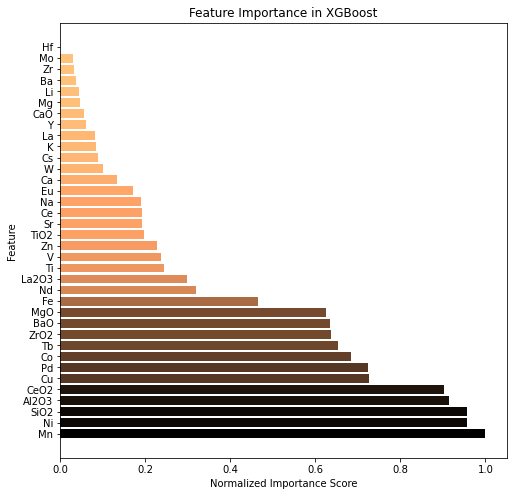

,Feature,Decision tree,DT prepruned,DT postpruned,Random forest,XGBoost
0,Ba,0.043448,0.016782,0.015632,0.003671,0.037036
1,Ca,0.104177,0.032347,0.032414,0.055456,0.134344
2,Ce,0.349826,0.131717,0.179657,0.101791,0.191433
3,Co,0.519474,0.470619,0.442338,0.465636,0.684667
4,Cs,0.107886,0.000000,0.059824,0.011351,0.088552
5,Cu,0.613454,0.543786,0.555956,0.625905,0.726331
6,Eu,0.289563,0.090879,0.119971,0.096846,0.170240
7,Fe,0.330453,0.179699,0.230992,0.321504,0.464637
8,Hf,0.045049,0.023900,0.015546,0.019163,0.000000
9,K,0.074084,0.017214,0.003937,0.046488,0.083756


In [ ]:
df_feature_importance = plot_feature_importance(feature_importances_XGBT, feature_names, model_name="XGBoost", df_feature_importance=df_feature_importance)
df_feature_importance

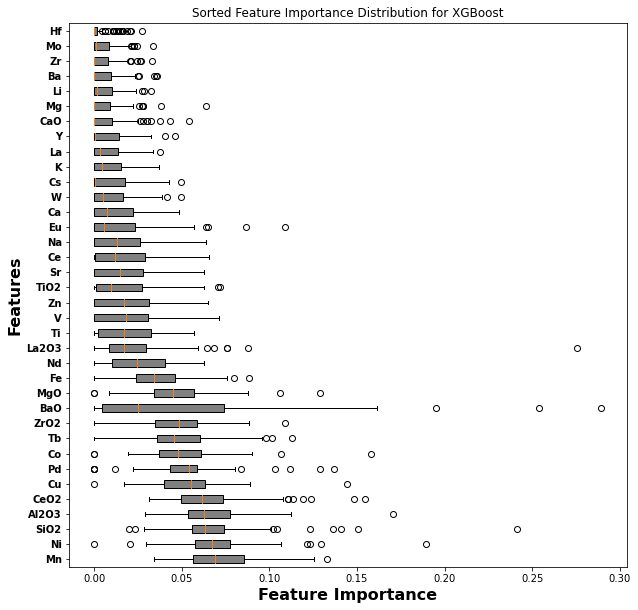

In [ ]:
plot_feature_importance_distribution(feature_importances_XGBT, feature_names, "XGBoost", color='gray')

## XGBoost without Resampling

In [ ]:
n = 100
acc_XGBT_nr = []
precision_XGBT_nr = []
recall_XGBT_nr = []
f1_XGBT_nr = []
learning_rate_XGBT_nr = []
n_estimators_XGBT_nr = []
reg_alphas_XGBT_nr = []
reg_lambdas_XGBT_nr = []
feature_importances_XGBT_nr = []

# Loop through different random splits
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)

    clf_XGBT = xgb.XGBClassifier(random_state=0)
    space = [Integer(1, 10, name='max_depth'),
             Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
             Real(10**-5, 10**0, "log-uniform", name='reg_alpha'),
             Real(10**-5, 10**0, "log-uniform", name='reg_lambda'),
             Integer(50, 500, name='n_estimators')]
    
    @use_named_args(space)
    def objective(**params):
        clf_XGBT.set_params(**params)
        return -np.mean(cross_val_score(clf_XGBT, X_train, y_train, cv=5, n_jobs=-1, scoring="f1"))
    
    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    
    clf_XGBT_optim = xgb.XGBClassifier(random_state=0, max_depth=res_gp.x[0], learning_rate=res_gp.x[1],
                                       reg_alpha=res_gp.x[2], reg_lambda=res_gp.x[3], n_estimators=res_gp.x[4])
    
    learning_rate_XGBT_nr.append(res_gp.x[1])
    n_estimators_XGBT_nr.append(res_gp.x[4])
    reg_alphas_XGBT_nr.append(res_gp.x[2])
    reg_lambdas_XGBT_nr.append(res_gp.x[3])
    
    clf_XGBT_optim.fit(X_train, y_train)
    y_pred = clf_XGBT_optim.predict(X_test)
    
    acc_XGBT_nr.append(accuracy_score(y_test, y_pred))
    precision_XGBT_nr.append(precision_score(y_test, y_pred, zero_division=1))
    recall_XGBT_nr.append(recall_score(y_test, y_pred))
    f1_XGBT_nr.append(f1_score(y_test, y_pred))
    
    # Save feature importances for this split
    feature_importances_XGBT_nr.append(clf_XGBT_optim.feature_importances_)

    if rs % 10 == 0:
        print("Split %s" % rs)


Split 0
Split 10
Split 20
Split 30
Split 40
Split 50
Split 60
Split 70
Split 80
Split 90


In [ ]:
df_metrics_nr = get_formatted_results(acc_XGBT_nr, f1_XGBT_nr, precision_XGBT_nr, recall_XGBT_nr, model_name="XGBoost", verbose=True, df_metrics = df_metrics_nr)

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.811356 │            0.0381002 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.403783 │            0.129963  │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.496583 │            0.154651  │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.351818 │            0.128343  │
╘═══════════╧══════════╧══════════════════════╛


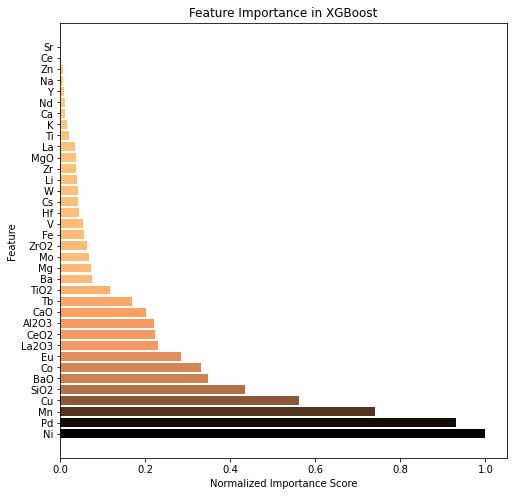

,Feature,Decision tree,DT prepruned,DT postpruned,Random forest,XGBoost
0,Ba,0.768629,0.495894,0.201020,0.269886,0.073365
1,Ca,0.496448,0.247061,0.080003,0.112287,0.010497
2,Ce,0.687321,0.319966,0.073332,0.244895,0.001954
3,Co,0.320590,0.185704,0.054516,0.074888,0.331536
4,Cs,0.457643,0.272984,0.056815,0.165847,0.041919
5,Cu,0.507390,0.209335,0.072497,0.141010,0.562042
6,Eu,0.923366,0.711945,0.481774,0.696226,0.284340
7,Fe,0.431689,0.163559,0.021093,0.124530,0.055921
8,Hf,0.370218,0.212451,0.026448,0.226595,0.044689
9,K,0.543470,0.407533,0.214106,0.216707,0.016551


In [ ]:
df_feature_importance_nr = plot_feature_importance(feature_importances_XGBT_nr, feature_names, model_name="XGBoost", df_feature_importance=df_feature_importance_nr)
df_feature_importance_nr

## COMPARISION OF FEATURE IMPORTANCES between various tree based models

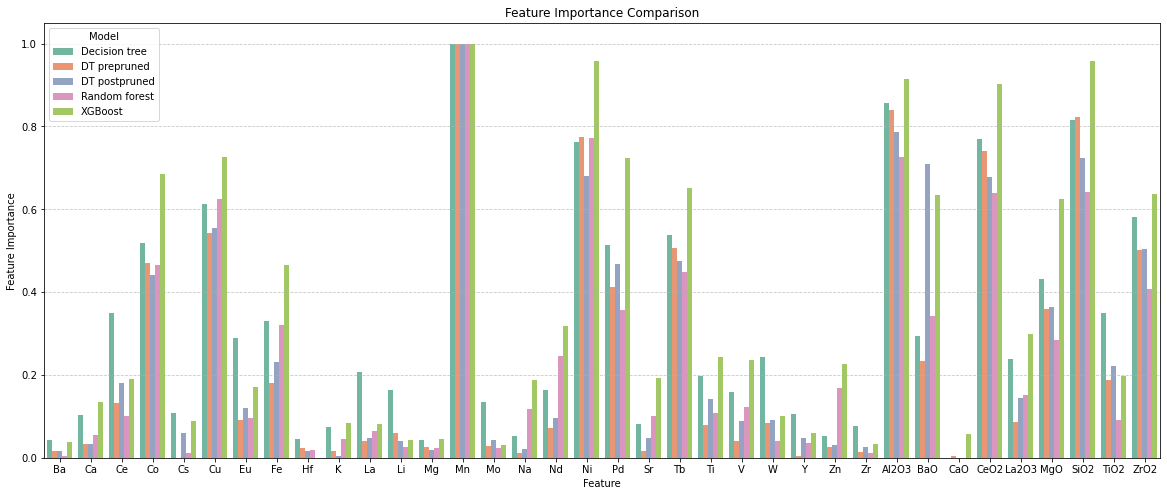

In [ ]:
# Melt the DataFrame to transform it into the suitable format for Plotly
df_melted = pd.melt(df_feature_importance, id_vars='Feature', var_name='Model', value_name='Importance')


# Set up the plot
plt.figure(figsize=(20, 8))

# Create a grouped bar plot
sns.barplot(x='Feature', y='Importance', hue='Model', data=df_melted, palette='Set2')

# Customize the plot
plt.title('Feature Importance Comparison')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Logistic regression

In [ ]:
n = 100
acc_logit = []
precision_logit = []
recall_logit = []
f1_logit = []

# Initialize an empty list to store feature importances
feature_importances_logit = []

for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    
    clf_logit = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = clf_logit.predict(X_test)
    acc_logit.append(accuracy_score(y_test, y_pred))
    precision_logit.append(precision_score(y_test, y_pred, zero_division=1))
    recall_logit.append(recall_score(y_test, y_pred))
    f1_logit.append(f1_score(y_test, y_pred))
    
    # Append the coefficients (feature importances) to the list
    feature_importances_logit.append(abs(clf_logit.coef_[0]))

In [ ]:
df_metrics = get_formatted_results(acc_logit, f1_logit, precision_logit, recall_logit, model_name="Logistic regression", verbose=True, df_metrics=df_metrics)
df_metrics 

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.784068 │            0.0488077 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.508313 │            0.101759  │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.448544 │            0.0968622 │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.601818 │            0.145897  │
╘═══════════╧══════════╧══════════════════════╛


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.457020,0.098570,0.395042,0.089219,0.560000,0.147553
1,DT prepruned,0.730339,0.063150,0.475768,0.083066,0.381914,0.074749,0.656364,0.155122
2,DT postpruned,0.808983,0.042397,0.500634,0.131402,0.493784,0.106958,0.538182,0.182127
3,Random forest,0.780678,0.049982,0.516662,0.090282,0.448324,0.087294,0.631818,0.146798
4,XGBoost,0.769322,0.052619,0.518977,0.087366,0.432281,0.077332,0.670909,0.153084
5,Logistic regression,0.784068,0.048808,0.508313,0.101759,0.448544,0.096862,0.601818,0.145897


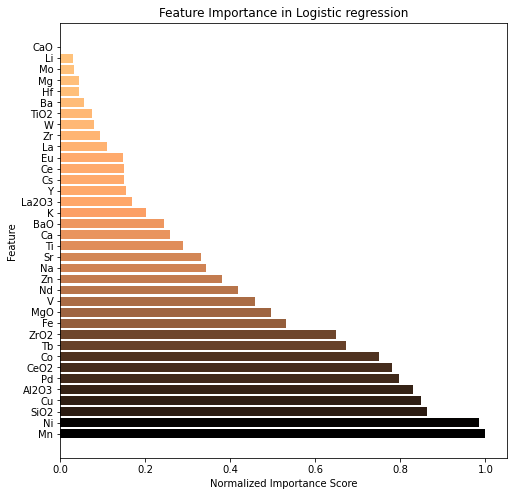

In [ ]:
df_feature_importance = plot_feature_importance(feature_importances_logit, feature_names, model_name="Logistic regression", df_feature_importance=df_feature_importance)

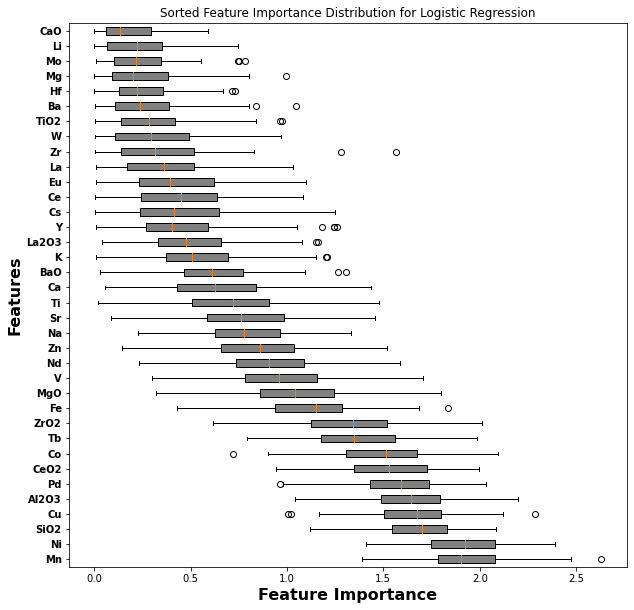

In [ ]:
plot_feature_importance_distribution(feature_importances_logit, feature_names, "Logistic Regression", color='gray')

## Logistic regression without Resampling

In [ ]:
n = 100
acc_logit_nr = []
precision_logit_nr = []
recall_logit_nr = []
f1_logit_nr = []

# Initialize an empty list to store feature importances
feature_importances_logit_nr = []

for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    
    clf_logit_nr = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred_nr = clf_logit_nr.predict(X_test)
    acc_logit_nr.append(accuracy_score(y_test, y_pred_nr))
    precision_logit_nr.append(precision_score(y_test, y_pred_nr, zero_division=1))
    recall_logit_nr.append(recall_score(y_test, y_pred_nr))
    f1_logit_nr.append(f1_score(y_test, y_pred_nr))
    
    # Append the coefficients (feature importances) to the list
    feature_importances_logit_nr.append(abs(clf_logit_nr.coef_[0]))


In [ ]:
df_metrics_nr = get_formatted_results(acc_logit_nr, f1_logit_nr, precision_logit_nr, recall_logit_nr, model_name="Logistic regression", verbose=True, df_metrics = df_metrics_nr)
df_metrics_nr

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.828814 │            0.0250825 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.305018 │            0.13586   │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.656492 │            0.251833  │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.212727 │            0.109257  │
╘═══════════╧══════════╧══════════════════════╛


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.764915,0.044435,0.369698,0.109174,0.376323,0.115006,0.375455,0.128985
1,DT prepruned,0.780508,0.040634,0.339334,0.130709,0.414449,0.176832,0.320000,0.149091
2,DT postpruned,0.827458,0.022913,0.318314,0.191723,0.697324,0.216694,0.255455,0.178929
3,Random forest,0.812203,0.021126,0.100531,0.116892,0.644595,0.414472,0.060909,0.072790
4,XGBoost,0.811356,0.038100,0.403783,0.129963,0.496583,0.154651,0.351818,0.128343
5,Logistic regression,0.828814,0.025082,0.305018,0.135860,0.656492,0.251833,0.212727,0.109257


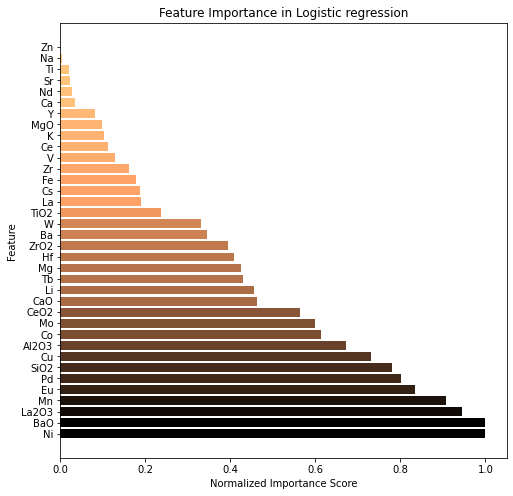

,Feature,Decision tree,DT prepruned,DT postpruned,Random forest,XGBoost,Logistic regression
0,Ba,0.768629,0.495894,0.201020,0.269886,0.073365,0.344519
1,Ca,0.496448,0.247061,0.080003,0.112287,0.010497,0.033422
2,Ce,0.687321,0.319966,0.073332,0.244895,0.001954,0.111833
3,Co,0.320590,0.185704,0.054516,0.074888,0.331536,0.611996
4,Cs,0.457643,0.272984,0.056815,0.165847,0.041919,0.188035
5,Cu,0.507390,0.209335,0.072497,0.141010,0.562042,0.729798
6,Eu,0.923366,0.711945,0.481774,0.696226,0.284340,0.834020
7,Fe,0.431689,0.163559,0.021093,0.124530,0.055921,0.178794
8,Hf,0.370218,0.212451,0.026448,0.226595,0.044689,0.408740
9,K,0.543470,0.407533,0.214106,0.216707,0.016551,0.102659


In [ ]:
df_feature_importance_nr = plot_feature_importance(feature_importances_logit_nr, feature_names, model_name="Logistic regression", df_feature_importance=df_feature_importance_nr)
df_feature_importance_nr

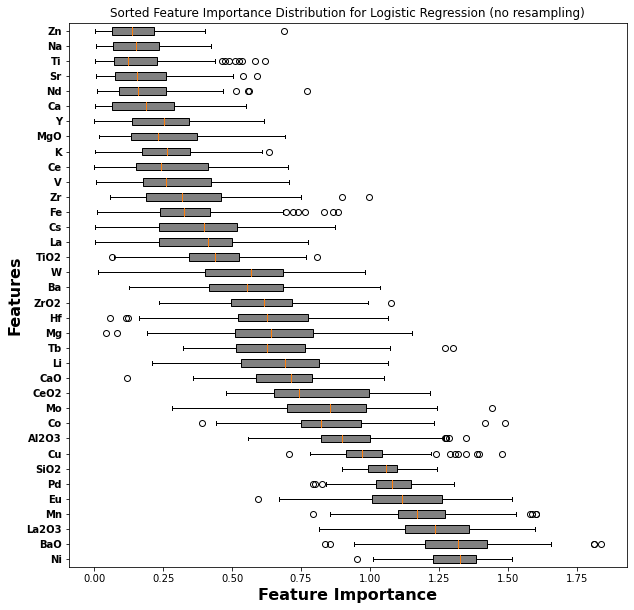

In [ ]:
plot_feature_importance_distribution(feature_importances_logit_nr, feature_names, "Logistic Regression (no resampling)", color='gray')

### SVM

In [ ]:
n = 100
acc_svm = []
precision_svm = []
recall_svm = []
f1_svm = []
kernels = []
Cs = []
gammas = []
feature_importances_svm = []

evaluated_points = {}  

# Loop through different random splits
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)

    clf_svm = SVC(random_state=0)
    
    # Define the space differently for different kernels
    space = [Categorical(['rbf'], name='kernel')]
    if 'rbf' in space[0]:
        space.append(Real(10**-2, 10**2, "log-uniform", name='C'))
        space.append(Real(10**-4, 10**1, "log-uniform", name='gamma'))
    else:
        space.append(Real(10**-2, 10**2, "log-uniform", name='C')) 
    
    @use_named_args(space)
    def objective(**params):
        params_key = tuple(sorted(params.items()))
        
        # Check if the point has been evaluated before
        if params_key in evaluated_points:
            return evaluated_points[params_key]  
        
        # Set the kernel parameter based on the space definition
        kernel = params['kernel']
        del params['kernel']  # Remove kernel from params
        
        clf_svm.set_params(kernel=kernel, **params)
        score = -np.mean(cross_val_score(clf_svm, X_train, y_train, cv=5, n_jobs=8, scoring="f1"))
        
        # Store the result
        evaluated_points[params_key] = score
        return score

    res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)
    
    # Adjust the model parameters based on the optimization results
    if 'rbf' in space[0]:
        clf_svm_optim = SVC(random_state=0, kernel=res_gp.x[0], C=res_gp.x[1], gamma=res_gp.x[2]) 
        Cs.append(res_gp.x[1])  # Store C values for rbf kernel
        gammas.append(res_gp.x[2])  # Store gamma values for rbf kernel
    else:
        clf_svm_optim = SVC(random_state=0, kernel=res_gp.x[0], C=res_gp.x[1], gamma='auto')  # Use C value of 1000 for non-rbf kernels
        Cs.append(res_gp.x[1])  # Store C values for non-rbf kernels
        gammas.append('auto')  # Store gamma as 'auto' for non-rbf kernels
    
    kernels.append(res_gp.x[0])

    clf_svm_optim.fit(X_train, y_train)
    y_pred = clf_svm_optim.predict(X_test)
    acc_svm.append(accuracy_score(y_test, y_pred))
    precision_svm.append(precision_score(y_test, y_pred, zero_division=1))
    recall_svm.append(recall_score(y_test, y_pred))
    f1_svm.append(f1_score(y_test, y_pred))
    
    result = permutation_importance(clf_svm_optim, X_test, y_test, n_repeats=10, random_state=0, n_jobs=8)
    feature_importances_svm.append(result.importances_mean)

    if rs % 10 == 0:
        print("Split %s" % rs)


Split 0
Split 10
Split 20
Split 30
Split 40
Split 50
Split 60
Split 70
Split 80
Split 90


In [ ]:
optimal_kernel = res_gp.x[0]
optimal_C = res_gp.x[1]
optimal_gamma = res_gp.x[2]  # Add this line to access the optimized gamma value

print("Optimal Kernel:", optimal_kernel)
print("Optimal C:", optimal_C)
print("Optimal Gamma:", optimal_gamma)  # Print the optimized gamma value


Optimal Kernel: rbf
Optimal C: 22.096070868729594
Optimal Gamma: 0.004863857046189474


In [ ]:
df_metrics = get_formatted_results(acc_svm, f1_svm, precision_svm, recall_svm, model_name="SVM", verbose=True, df_metrics=df_metrics)
df_metrics

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.771864 │            0.0527563 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.493774 │            0.0976897 │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.42971  │            0.0951308 │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.597273 │            0.142153  │
╘═══════════╧══════════╧══════════════════════╛


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.457020,0.098570,0.395042,0.089219,0.560000,0.147553
1,DT prepruned,0.730339,0.063150,0.475768,0.083066,0.381914,0.074749,0.656364,0.155122
2,DT postpruned,0.808983,0.042397,0.500634,0.131402,0.493784,0.106958,0.538182,0.182127
3,Random forest,0.780678,0.049982,0.516662,0.090282,0.448324,0.087294,0.631818,0.146798
4,XGBoost,0.769322,0.052619,0.518977,0.087366,0.432281,0.077332,0.670909,0.153084
5,Logistic regression,0.784068,0.048808,0.508313,0.101759,0.448544,0.096862,0.601818,0.145897
6,SVM,0.771864,0.052756,0.493774,0.097690,0.429710,0.095131,0.597273,0.142153


In [ ]:
# we do noy use the "permutation_importance". The SVM will be converted to neuralized SVM, in another script and LRP will be used to explain the model.

# SVM without Resampling

In [ ]:
n = 100
acc_svm_nr = []
precision_svm_nr = []
recall_svm_nr = []
f1_svm_nr = []
kernels_nr = []
Cs_nr = []
gammas_nr = []
feature_importances_svm_nr = []

evaluated_points = {}  

# Loop through different random splits
for rs in range(n):
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs * 1234 + 567)
    #X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)

    clf_svm_nr = SVC(random_state=0)
    
    # Define the space differently for different kernels
    space = [Categorical(['rbf'], name='kernel')]
    if 'rbf' in space[0]:
        space.append(Real(10**-2, 10**2, "log-uniform", name='C'))
        space.append(Real(10**-4, 10**1, "log-uniform", name='gamma'))
    else:
        space.append(Real(10**-2, 10**2, "log-uniform", name='C')) 
    
    @use_named_args(space)
    def objective(**params):
        params_key = tuple(sorted(params.items()))
        
        # Check if the point has been evaluated before
        if params_key in evaluated_points:
            return evaluated_points[params_key]  
        
        # Set the kernel parameter based on the space definition
        kernel = params['kernel']
        del params['kernel']  # Remove kernel from params
        
        clf_svm_nr.set_params(kernel=kernel, **params)
        score = -np.mean(cross_val_score(clf_svm_nr, X_train, y_train, cv=5, n_jobs=8, scoring="f1"))
        
        # Store the result
        evaluated_points[params_key] = score
        return score

    res_gp_svm_nr = gp_minimize(objective, space, n_calls=30, random_state=0)
    
    # Adjust the model parameters based on the optimization results
    if 'rbf' in space[0]:
        clf_svm_optim_nr = SVC(random_state=0, kernel=res_gp_svm_nr.x[0], C=res_gp_svm_nr.x[1], gamma=res_gp_svm_nr.x[2]) 
        Cs_nr.append(res_gp_svm_nr.x[1])  # Store C values for rbf kernel
        gammas_nr.append(res_gp_svm_nr.x[2])  # Store gamma values for rbf kernel
    else:
        clf_svm_optim_nr = SVC(random_state=0, kernel=res_gp_svm_nr.x[0], C=res_gp_svm_nr.x[1], gamma='auto')  # Use C value of 1000 for non-rbf kernels
        Cs_nr.append(res_gp_svm_nr.x[1])  # Store C values for non-rbf kernels
        gammas_nr.append('auto')  # Store gamma as 'auto' for non-rbf kernels
    
    kernels_nr.append(res_gp_svm_nr.x[0])

    clf_svm_optim_nr.fit(X_train, y_train)
    y_pred = clf_svm_optim_nr.predict(X_test)
    acc_svm_nr.append(accuracy_score(y_test, y_pred))
    precision_svm_nr.append(precision_score(y_test, y_pred, zero_division=1))
    recall_svm_nr.append(recall_score(y_test, y_pred))
    f1_svm_nr.append(f1_score(y_test, y_pred))
    
    result = permutation_importance(clf_svm_optim_nr, X_test, y_test, n_repeats=10, random_state=0, n_jobs=8)
    feature_importances_svm_nr.append(result.importances_mean)

    if rs % 10 == 0:
        print("Split %s" % rs)


Split 0
Split 10
Split 20
Split 30
Split 40
Split 50
Split 60
Split 70
Split 80
Split 90


In [ ]:
optimal_kernel = res_gp_svm_nr.x[0]
optimal_C = res_gp_svm_nr.x[1]
optimal_gamma = res_gp_svm_nr.x[2]  # Add this line to access the optimized gamma value

print("Optimal Kernel:", optimal_kernel)
print("Optimal C:", optimal_C)
print("Optimal Gamma:", optimal_gamma)  # Print the optimized gamma value


Optimal Kernel: rbf
Optimal C: 100.0
Optimal Gamma: 0.0168687040355771


In [ ]:
df_metrics_nr = get_formatted_results(acc_svm_nr, f1_svm_nr, precision_svm_nr, recall_svm_nr, model_name="SVM", verbose=True, df_metrics = df_metrics_nr)
df_metrics_nr 

╒═══════════╤══════════╤══════════════════════╕
│ Metric    │     Mean │   Standard Deviation │
╞═══════════╪══════════╪══════════════════════╡
│ Accuracy  │ 0.822881 │            0.0364604 │
├───────────┼──────────┼──────────────────────┤
│ F1 Score  │ 0.483813 │            0.107127  │
├───────────┼──────────┼──────────────────────┤
│ Precision │ 0.545065 │            0.125877  │
├───────────┼──────────┼──────────────────────┤
│ Recall    │ 0.454545 │            0.134226  │
╘═══════════╧══════════╧══════════════════════╛


,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.764915,0.044435,0.369698,0.109174,0.376323,0.115006,0.375455,0.128985
1,DT prepruned,0.780508,0.040634,0.339334,0.130709,0.414449,0.176832,0.320000,0.149091
2,DT postpruned,0.827458,0.022913,0.318314,0.191723,0.697324,0.216694,0.255455,0.178929
3,Random forest,0.812203,0.021126,0.100531,0.116892,0.644595,0.414472,0.060909,0.072790
4,XGBoost,0.811356,0.038100,0.403783,0.129963,0.496583,0.154651,0.351818,0.128343
5,Logistic regression,0.828814,0.025082,0.305018,0.135860,0.656492,0.251833,0.212727,0.109257
6,SVM,0.822881,0.036460,0.483813,0.107127,0.545065,0.125877,0.454545,0.134226


In [ ]:
# drop the last row  of df_metrics and reset the index
df_metrics

,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.457020,0.098570,0.395042,0.089219,0.560000,0.147553
1,DT prepruned,0.730339,0.063150,0.475768,0.083066,0.381914,0.074749,0.656364,0.155122
2,DT postpruned,0.808983,0.042397,0.500634,0.131402,0.493784,0.106958,0.538182,0.182127
3,Random forest,0.780678,0.049982,0.516662,0.090282,0.448324,0.087294,0.631818,0.146798
4,XGBoost,0.769322,0.052619,0.518977,0.087366,0.432281,0.077332,0.670909,0.153084
5,Logistic regression,0.784068,0.048808,0.508313,0.101759,0.448544,0.096862,0.601818,0.145897
6,SVM,0.771864,0.052756,0.493774,0.097690,0.429710,0.095131,0.597273,0.142153


In [ ]:
## SAVING ANALYSIS RESULTS
df_metrics.to_csv('/Users/parastoo/phd_projects/OCM/csv_files/metrics_results.csv', index=False)
df_metrics_nr.to_csv('/Users/parastoo/phd_projects/OCM/csv_files/metrics_NO_Resampling_results.csv', index=False)
df_feature_importance.to_csv('/Users/parastoo/phd_projects/OCM/csv_files/feature_imp_with_sklearn_results.csv', index=False)
df_feature_importance_nr.to_csv('/Users/parastoo/phd_projects/OCM/csv_files/feature_imp_with_sklearn_NO_Resampling_results.csv', index=False)


In [ ]:
# Reading the Excel files 
# df_metrics= pd.read_csv('/Users/parastoo/phd_projects/OCM/csv_files/metrics_results.csv')
# df_metrics_nr= pd.read_csv('/Users/parastoo/phd_projects/OCM/csv_files/metrics_NO_Resampling_results.csv')
# df_feature_importance = pd.read_csv('/Users/parastoo/phd_projects/OCM/csv_files/feature_imp_with_sklearn_results.csv')
# df_feature_importance_nr = pd.read_csv('/Users/parastoo/phd_projects/OCM/csv_files/feature_imp_with_sklearn_NO_Resampling_results.csv')


## Importing the analysis from Neural Networks and LRP

In [ ]:
file_path = '/Users/parastoo/phd_projects/OCM/results_neural/analysis_with_data_resampling/mlp_metrics_lrp_bias_True_art_neuron_True_wd_0.001_resampling_True.csv'
df_nn_metrics = pd.read_csv(file_path)
df_nn_metrics

,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Neural Networks,0.750169,0.049218,0.505362,0.100121,0.403772,0.0822,0.694545,0.173215


In [ ]:
# Append the new data to df_metrics
df_metrics = df_metrics.append(df_nn_metrics, ignore_index=True)
df_metrics

,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.753898,0.052212,0.457020,0.098570,0.395042,0.089219,0.560000,0.147553
1,DT prepruned,0.730339,0.063150,0.475768,0.083066,0.381914,0.074749,0.656364,0.155122
2,DT postpruned,0.808983,0.042397,0.500634,0.131402,0.493784,0.106958,0.538182,0.182127
3,Random forest,0.780678,0.049982,0.516662,0.090282,0.448324,0.087294,0.631818,0.146798
4,XGBoost,0.769322,0.052619,0.518977,0.087366,0.432281,0.077332,0.670909,0.153084
5,Logistic regression,0.784068,0.048808,0.508313,0.101759,0.448544,0.096862,0.601818,0.145897
6,SVM,0.771864,0.052756,0.493774,0.097690,0.429710,0.095131,0.597273,0.142153
7,Neural Networks,0.750169,0.049218,0.505362,0.100121,0.403772,0.082200,0.694545,0.173215


## Converting the df_metrics and saving it for exporting

In [ ]:
df_metrics_accandF1 = df_metrics[['Model', 'Accuracy_Mean', 'Accuracy_Std' ,'F1_Mean', 'F1_Std']]

# Round the numeric columns to two decimal places
df_metrics_accandF1[['Accuracy_Mean', 'Accuracy_Std' ,'F1_Mean', 'F1_Std']] = df_metrics_accandF1[['Accuracy_Mean', 'Accuracy_Std' ,'F1_Mean', 'F1_Std']].round(2)

# Save the new DataFrame to a CSV file
file_path = '/Users/parastoo/phd_projects/OCM/csv_files/Model_Comparison_accuracyandF1.csv'  # Specify the file path
df_metrics_accandF1.to_csv(file_path, index=False)

# Print the new DataFrame
print(df_metrics_accandF1)


                 Model  Accuracy_Mean  Accuracy_Std  F1_Mean  F1_Std
0        Decision Tree           0.75          0.05     0.46    0.10
1         DT prepruned           0.73          0.06     0.48    0.08
2        DT postpruned           0.81          0.04     0.50    0.13
3        Random forest           0.78          0.05     0.52    0.09
4              XGBoost           0.77          0.05     0.52    0.09
5  Logistic regression           0.78          0.05     0.51    0.10
6                  SVM           0.77          0.05     0.49    0.10
7      Neural Networks           0.75          0.05     0.51    0.10


In [ ]:
df_metrics_complete = df_metrics.copy()

# Exclude the first column (assuming it's non-numeric)
numeric_cols = df_metrics_complete.columns[1:]

# Convert the numeric columns to float type
df_metrics_complete[numeric_cols] = df_metrics_complete[numeric_cols].astype(float)

# Round the values in the numeric columns to two decimal places
df_metrics_complete[numeric_cols] = df_metrics_complete[numeric_cols].round(2)

# Print the rounded DataFrame
print(df_metrics_complete)

# Specify the file path
file_path = '/Users/parastoo/phd_projects/OCM/csv_files/data_for_model_comparision_complete.csv'

# Save the rounded DataFrame to a CSV file
df_metrics_complete.to_csv(file_path, index=False)

                 Model  Accuracy_Mean  Accuracy_Std  F1_Mean  F1_Std  \
0        Decision Tree           0.75          0.05     0.46    0.10   
1         DT prepruned           0.73          0.06     0.48    0.08   
2        DT postpruned           0.81          0.04     0.50    0.13   
3        Random forest           0.78          0.05     0.52    0.09   
4              XGBoost           0.77          0.05     0.52    0.09   
5  Logistic regression           0.78          0.05     0.51    0.10   
6                  SVM           0.77          0.05     0.49    0.10   
7      Neural Networks           0.75          0.05     0.51    0.10   

   Precision_Mean  Precision_Std  Recall_Mean  Recall_Std  
0            0.40           0.09         0.56        0.15  
1            0.38           0.07         0.66        0.16  
2            0.49           0.11         0.54        0.18  
3            0.45           0.09         0.63        0.15  
4            0.43           0.08         0.67      

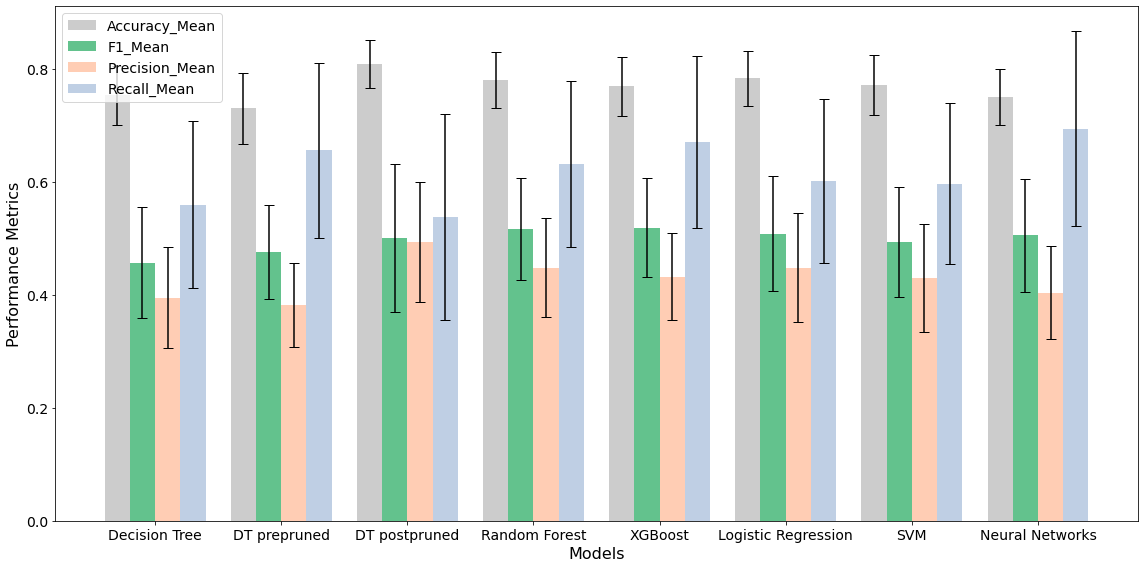

In [ ]:

selected_models = ['Decision Tree','DT prepruned', 'DT postpruned', 'Random forest', 'XGBoost', 'Logistic regression','SVM', 'Neural Networks']

# Filter the dataframe to include only the selected models
df_selected_metrics = df_metrics[df_metrics['Model'].isin(selected_models)]

# Define colors for each metric
#colors = ['saddlebrown', 'olivedrab', 'rosybrown', 'gray' ]
#colors = ['#377eb8', '#ff7f00', '#4daf4a', '#984ea3']
colors = ['#c0c0c0', '#3cb371', '#ffc1a1', '#b0c4de']

# Extract data for plotting
models = df_selected_metrics['Model']
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
mean_columns = [f'{metric}_Mean' for metric in metrics]
std_columns = [f'{metric}_Std' for metric in metrics]
mean_values = df_selected_metrics[mean_columns].values
std_values = df_selected_metrics[std_columns].values

# Plotting
bar_width = 0.2
opacity = 0.8
index = np.arange(len(models))

fig, ax = plt.subplots(figsize=(16, 8))

for i, metric in enumerate(metrics):
    mean_data = mean_values[:, i]
    std_data = std_values[:, i]
    ax.bar(index + i * bar_width, mean_data, bar_width,
           alpha=opacity, label=f'{metric}_Mean', yerr=std_data, capsize=5, color=colors[i])

# Adjust font sizes and labels for selected models
fontsize = 14
ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Performance Metrics', fontsize=16)
#ax.set_title('Comparison of Model Performance Metrics', fontsize=fontsize)
ax.set_xticks(index + (bar_width * (len(metrics) - 1)) / 2)
ax.set_xticklabels(['Decision Tree','DT prepruned', 'DT postpruned', 'Random Forest', 'XGBoost', 'Logistic Regression', 'SVM', 'Neural Networks'], fontsize=fontsize)
plt.yticks(fontsize=14)
ax.legend(fontsize=fontsize)

plt.tight_layout()

# Save the figure
plt.savefig("/Users/parastoo/phd_projects/OCM/plots/Model_Performance_Comparision_with_Resampling_new.png", facecolor=(1,1,1,0), bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
df_metrics_nr

,Model,Accuracy_Mean,Accuracy_Std,F1_Mean,F1_Std,Precision_Mean,Precision_Std,Recall_Mean,Recall_Std
0,Decision Tree,0.764915,0.044435,0.369698,0.109174,0.376323,0.115006,0.375455,0.128985
1,DT prepruned,0.780508,0.040634,0.339334,0.130709,0.414449,0.176832,0.320000,0.149091
2,DT postpruned,0.827458,0.022913,0.318314,0.191723,0.697324,0.216694,0.255455,0.178929
3,Random forest,0.812203,0.021126,0.100531,0.116892,0.644595,0.414472,0.060909,0.072790
4,XGBoost,0.811356,0.038100,0.403783,0.129963,0.496583,0.154651,0.351818,0.128343
5,Logistic regression,0.828814,0.025082,0.305018,0.135860,0.656492,0.251833,0.212727,0.109257
6,SVM,0.822881,0.036460,0.483813,0.107127,0.545065,0.125877,0.454545,0.134226


In [ ]:
## Read the data from the saved CSV files for neural networks with no resampling

In [ ]:
file_path = '/Users/parastoo/phd_projects/OCM/Robustness check & alternative methods/results_neural/analysis_without_data_resampling/mlp_metrics_lrp_bias_True_art_neuron_True_wd_0.001_resampling_False.csv'
df_nn_metrics_nr = pd.read_csv(file_path)

# Append the new data to df_metrics
df_metrics_nr = df_metrics_nr.append(df_nn_metrics_nr, ignore_index=True)

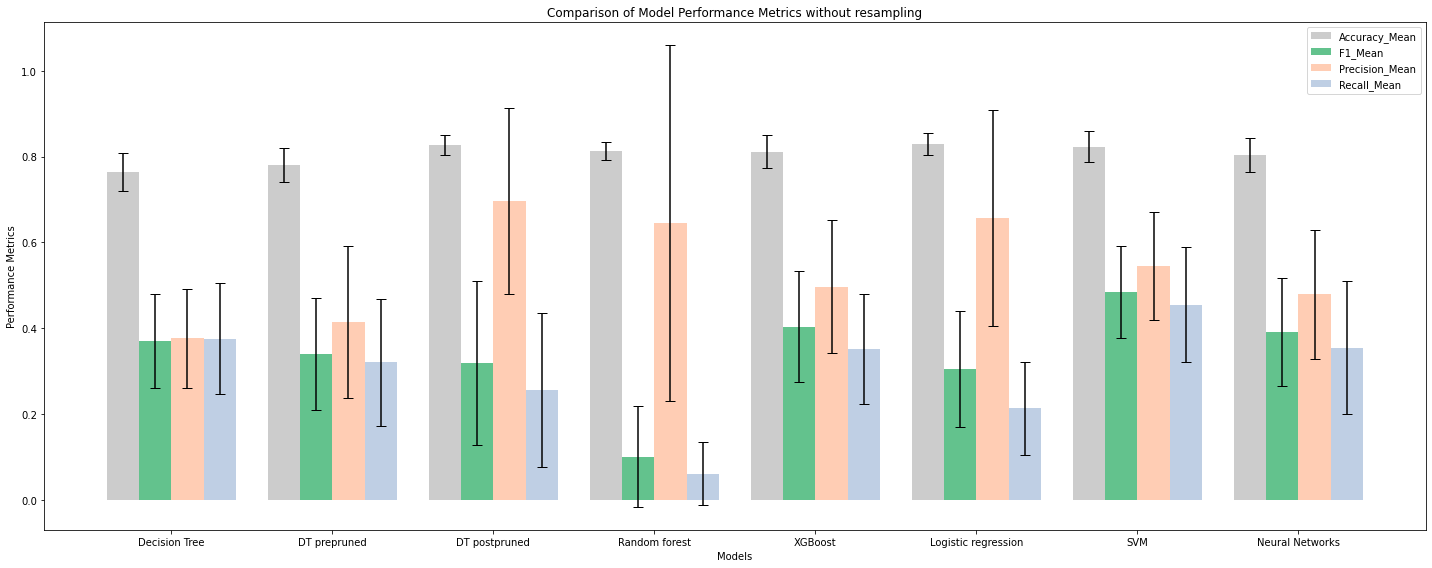

In [ ]:
colors = ['#c0c0c0', '#3cb371', '#ffc1a1', '#b0c4de']
models = df_metrics_nr['Model']
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
mean_columns = [f'{metric}_Mean' for metric in metrics]
std_columns = [f'{metric}_Std' for metric in metrics]
mean_values = df_metrics_nr[mean_columns].values
std_values = df_metrics_nr[std_columns].values

# Plotting
bar_width = 0.2
opacity = 0.8
index = np.arange(len(models))

fig, ax = plt.subplots(figsize=(20, 8))

for i, metric in enumerate(metrics):
    mean_data = mean_values[:, i]
    std_data = std_values[:, i]
    ax.bar(index + i * bar_width, mean_data, bar_width,
           alpha=opacity, label=f'{metric}_Mean', yerr=std_data, capsize=5, color=colors[i])

ax.set_xlabel('Models')
ax.set_ylabel('Performance Metrics')
ax.set_title('Comparison of Model Performance Metrics without resampling')
ax.set_xticks(index + (bar_width * (len(metrics) - 1)) / 2)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
fig.savefig("/Users/parastoo/phd_projects/OCM/plots/Model_Performance_Comparision_without_Resampling_new.png", facecolor=(1,1,1,0), bbox_inches='tight')

plt.show()


In [ ]:
df_metrics_accandF1_nr = df_metrics_nr[['Model', 'Accuracy_Mean', 'Accuracy_Std' ,'F1_Mean', 'F1_Std']]

# Round the numeric columns to two decimal places
df_metrics_accandF1_nr[['Accuracy_Mean', 'Accuracy_Std' ,'F1_Mean', 'F1_Std']] = df_metrics_accandF1_nr[['Accuracy_Mean', 'Accuracy_Std' ,'F1_Mean', 'F1_Std']].round(2)

# Save the new DataFrame to a CSV file
file_path = '/Users/parastoo/phd_projects/OCM/csv_files/Model_Comparison_accuracyandF1_nr_new.csv'  # Specify the file path
df_metrics_accandF1_nr.to_csv(file_path, index=False)

# Print the new DataFrame
print(df_metrics_accandF1_nr)

                 Model  Accuracy_Mean  Accuracy_Std  F1_Mean  F1_Std
0        Decision Tree           0.76          0.04     0.37    0.11
1         DT prepruned           0.78          0.04     0.34    0.13
2        DT postpruned           0.83          0.02     0.32    0.19
3        Random forest           0.81          0.02     0.10    0.12
4              XGBoost           0.81          0.04     0.40    0.13
5  Logistic regression           0.83          0.03     0.31    0.14
6                  SVM           0.82          0.04     0.48    0.11
7      Neural Networks           0.80          0.04     0.39    0.13


In [ ]:
# Rename columns in df_metrics_nr to distinguish from df_metrics
df_metrics_nr_renamed = df_metrics_nr.rename(columns={
    'Accuracy_Mean': 'Accuracy_Mean_nr',
    'Accuracy_Std': 'Accuracy_Std_nr',
    'F1_Mean': 'F1_Mean_nr',
    'F1_Std': 'F1_Std_nr',
    'Precision_Mean': 'Precision_Mean_nr',
    'Precision_Std': 'Precision_Std_nr',
    'Recall_Mean': 'Recall_Mean_nr',
    'Recall_Std': 'Recall_Std_nr'
})

# Merge the two DataFrames on the 'Model' column
merged_df = pd.merge(df_metrics, df_metrics_nr_renamed, on='Model')


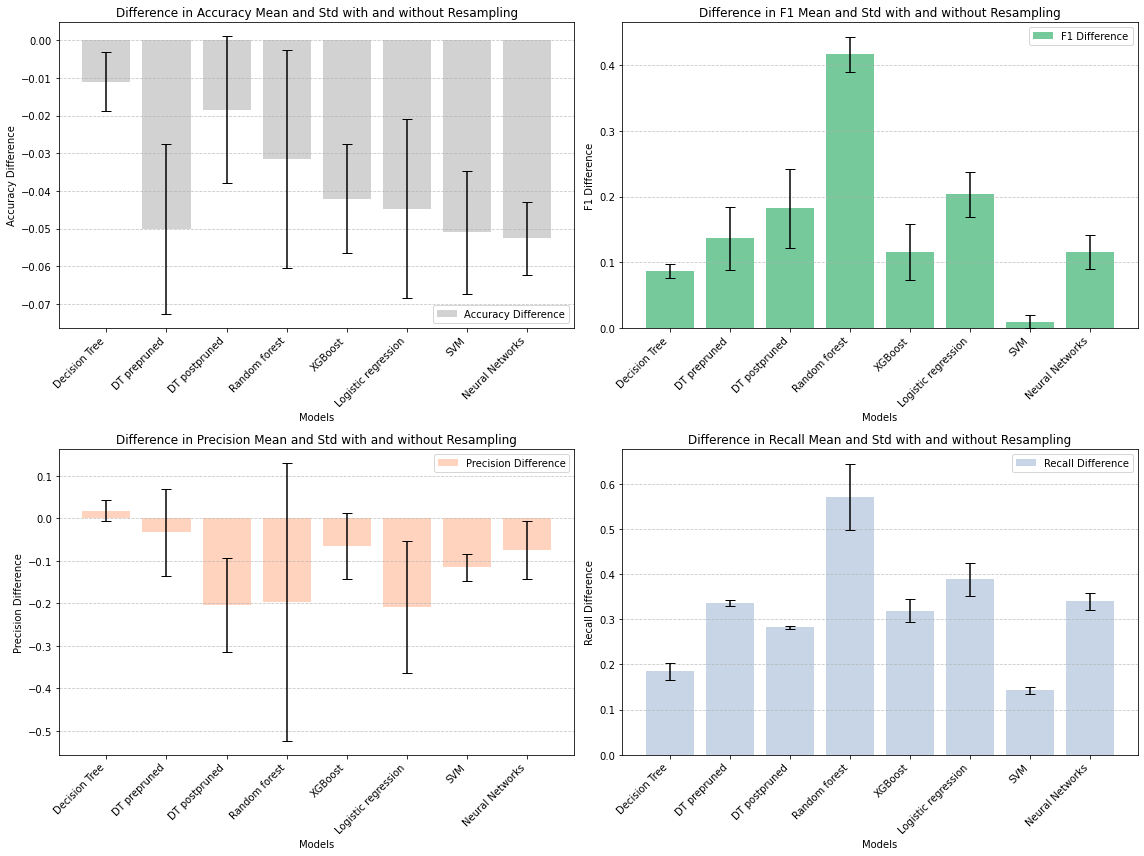

In [ ]:
# Define the metrics
metrics = ['Accuracy', 'F1', 'Precision', 'Recall']

# Create individual plots for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

colors = ['#c0c0c0', '#3cb371', '#ffc1a1', '#b0c4de']
# Reshape axes to fit the new layout
axes = axes.flatten()

for i, metric in enumerate(metrics):
    # Extract relevant columns
    mean_metrics_column = f'{metric}_Mean'
    std_metrics_column = f'{metric}_Std'
    mean_metrics_nr_column = f'{metric}_Mean_nr'
    std_metrics_nr_column = f'{metric}_Std_nr'

    # Calculate the differences
    mean_diff = merged_df[mean_metrics_column] - merged_df[mean_metrics_nr_column]
    std_diff = merged_df[std_metrics_column] - merged_df[std_metrics_nr_column]

    # Create a bar plot with error bars
    models = merged_df['Model']
    index = np.arange(len(models))

    bars = axes[i].bar(index, mean_diff, yerr=std_diff, capsize=5, alpha=0.7, label=f'{metric} Difference', color=colors[i])

    axes[i].set_xlabel('Models')
    axes[i].set_ylabel(f'{metric} Difference')
    axes[i].set_title(f'Difference in {metric} Mean and Std with and without Resampling')
    axes[i].set_xticks(index)
    axes[i].set_xticklabels(models, rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    axes[i].legend()

    # Add grid lines for better readability
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig("/Users/parastoo/phd_projects/OCM/plots/Difference_between_Metrics_with_and_without_Resampling.png", facecolor=(1,1,1,0), bbox_inches='tight', dpi=300)
plt.show()


# feature importance

In [ ]:
def normalize_column(df, column_name, range_min=0, range_max=1):
    """
    Normalize the values of a column in a DataFrame to a specified range [range_min, range_max].

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column to be normalized.
    - column_name (str): The name of the column to be normalized.
    - range_min (float): The minimum value of the normalized range.
    - range_max (float): The maximum value of the normalized range.

    Returns:
    - pd.DataFrame: The DataFrame with the normalized column.
    """
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val) * (range_max - range_min) + range_min
    return df


## importing the LRP values for SVM and Neural Networks

In [ ]:
# SVM relevance scores
file_path = '//Users/parastoo/phd_projects/OCM/Explaining_SVM/results/sorted_mean_lrp_SVM.csv'
df_LRP_SVM = pd.read_csv(file_path)
#append it to the df_feature_importance
df_feature_importance['SVM'] = df_LRP_SVM['Mean_LRP_Score']
df_feature_importance


,Feature,Decision tree,DT prepruned,DT postpruned,Random forest,XGBoost,Logistic regression,SVM_skl,SVM
0,Ba,0.043448,0.016782,0.015632,0.003671,0.037036,0.055603,0.046940,0.237601
1,Ca,0.104177,0.032347,0.032414,0.055456,0.134344,0.258620,0.100782,-0.119890
2,Ce,0.349826,0.131717,0.179657,0.101791,0.191433,0.149011,0.120110,-0.012784
3,Co,0.519474,0.470619,0.442338,0.465636,0.684666,0.749142,0.480442,-0.328173
4,Cs,0.107886,0.000000,0.059824,0.011351,0.088552,0.150828,0.032674,0.012777
5,Cu,0.613454,0.543786,0.555956,0.625905,0.726331,0.847866,0.612977,-0.362152
6,Eu,0.289563,0.090879,0.119971,0.096846,0.170240,0.146581,0.014266,0.315034
7,Fe,0.330453,0.179699,0.230992,0.321504,0.464637,0.529923,0.646111,-0.366119
8,Hf,0.045049,0.023900,0.015546,0.019163,0.000000,0.043139,0.000000,0.116007
9,K,0.074084,0.017214,0.003937,0.046488,0.083756,0.200455,0.095260,-0.108822


In [ ]:
# SVM relevance scores ABSOLUTE 
file_path = '//Users/parastoo/phd_projects/OCM/Explaining_SVM/results/sorted_mean_abs_lrp_SVM.csv'
df_LRP_SVM_abs = pd.read_csv(file_path)
#append it to the df_feature_importance
df_feature_importance['SVM_abs'] = df_LRP_SVM_abs['Mean_Absolute_LRP_Score']
df_feature_importance


,Feature,Decision tree,DT prepruned,DT postpruned,Random forest,XGBoost,Logistic regression,SVM,SVM_abs
0,Ba,0.043448,0.016782,0.015632,0.003671,0.037036,0.055603,0.237601,0.343899
1,Ca,0.104177,0.032347,0.032414,0.055456,0.134344,0.258620,-0.119890,0.153679
2,Ce,0.349826,0.131717,0.179657,0.101791,0.191433,0.149011,-0.012784,0.299260
3,Co,0.519474,0.470619,0.442338,0.465636,0.684666,0.749142,-0.328173,0.328173
4,Cs,0.107886,0.000000,0.059824,0.011351,0.088552,0.150828,0.012777,0.163764
5,Cu,0.613454,0.543786,0.555956,0.625905,0.726331,0.847866,-0.362152,0.362152
6,Eu,0.289563,0.090879,0.119971,0.096846,0.170240,0.146581,0.315034,0.336945
7,Fe,0.330453,0.179699,0.230992,0.321504,0.464637,0.529923,-0.366119,0.366119
8,Hf,0.045049,0.023900,0.015546,0.019163,0.000000,0.043139,0.116007,0.251536
9,K,0.074084,0.017214,0.003937,0.046488,0.083756,0.200455,-0.108822,0.177359


In [ ]:
#read data from the csv file
#file_path = '/Users/parastoo/phd_projects/OCM/csv_files/feature_importance_g_abs_new.csv'
#lcr
file_path = '/Users/parastoo/Downloads/FI_nn_WithRebalancing_positive_class_bias_True_art_neuron_True_wd_0.001.csv'
df_LRP_NN = pd.read_csv(file_path)
#append it to the df_feature_importance
df_feature_importance['Neural_Networks'] = df_LRP_NN['Importance Score']
df_feature_importance


,Feature,Decision tree,DT prepruned,DT postpruned,Random forest,XGBoost,Logistic regression,SVM,SVM_abs,Neural_Networks
0,Ba,0.043448,0.016782,0.015632,0.003671,0.037036,0.055603,0.237601,0.343899,-0.000297
1,Ca,0.104177,0.032347,0.032414,0.055456,0.134344,0.258620,-0.119890,0.153679,-0.013739
2,Ce,0.349826,0.131717,0.179657,0.101791,0.191433,0.149011,-0.012784,0.299260,-0.000842
3,Co,0.519474,0.470619,0.442338,0.465636,0.684666,0.749142,-0.328173,0.328173,-0.104310
4,Cs,0.107886,0.000000,0.059824,0.011351,0.088552,0.150828,0.012777,0.163764,0.000969
5,Cu,0.613454,0.543786,0.555956,0.625905,0.726331,0.847866,-0.362152,0.362152,-0.146333
6,Eu,0.289563,0.090879,0.119971,0.096846,0.170240,0.146581,0.315034,0.336945,0.062291
7,Fe,0.330453,0.179699,0.230992,0.321504,0.464637,0.529923,-0.366119,0.366119,-0.063758
8,Hf,0.045049,0.023900,0.015546,0.019163,0.000000,0.043139,0.116007,0.251536,0.018118
9,K,0.074084,0.017214,0.003937,0.046488,0.083756,0.200455,-0.108822,0.177359,-0.016330


In [ ]:
file_path = '/Users/parastoo/Downloads/FI_nn_abs_WithRebalancing_positive_class_bias_True_art_neuron_True_wd_0.001.csv'
df_LRP_NN = pd.read_csv(file_path)
#append it to the df_feature_importance
df_feature_importance['Neural_Networks_abs'] = df_LRP_NN['Importance Score']
df_feature_importance


,Feature,Decision tree,DT prepruned,DT postpruned,Random forest,XGBoost,Logistic regression,SVM,SVM_abs,Neural_Networks,Neural_Networks_abs
0,Ba,0.043448,0.016782,0.015632,0.003671,0.037036,0.055603,0.237601,0.343899,-0.000297,0.041001
1,Ca,0.104177,0.032347,0.032414,0.055456,0.134344,0.258620,-0.119890,0.153679,-0.013739,0.029921
2,Ce,0.349826,0.131717,0.179657,0.101791,0.191433,0.149011,-0.012784,0.299260,-0.000842,0.035919
3,Co,0.519474,0.470619,0.442338,0.465636,0.684666,0.749142,-0.328173,0.328173,-0.104310,0.105238
4,Cs,0.107886,0.000000,0.059824,0.011351,0.088552,0.150828,0.012777,0.163764,0.000969,0.031136
5,Cu,0.613454,0.543786,0.555956,0.625905,0.726331,0.847866,-0.362152,0.362152,-0.146333,0.148496
6,Eu,0.289563,0.090879,0.119971,0.096846,0.170240,0.146581,0.315034,0.336945,0.062291,0.064929
7,Fe,0.330453,0.179699,0.230992,0.321504,0.464637,0.529923,-0.366119,0.366119,-0.063758,0.068729
8,Hf,0.045049,0.023900,0.015546,0.019163,0.000000,0.043139,0.116007,0.251536,0.018118,0.036246
9,K,0.074084,0.017214,0.003937,0.046488,0.083756,0.200455,-0.108822,0.177359,-0.016330,0.040210


Normalizing SVM and Neural Network values

In [ ]:
df_feature_importance = normalize_column(df_feature_importance, 'SVM', range_min=-1, range_max=1)
df_feature_importance = normalize_column(df_feature_importance, 'Neural_Networks', range_min=-1, range_max=1)
df_feature_importance = normalize_column(df_feature_importance, 'SVM_abs', range_min=0, range_max=1)
df_feature_importance = normalize_column(df_feature_importance, 'Neural_Networks_abs', range_min=0, range_max=1)

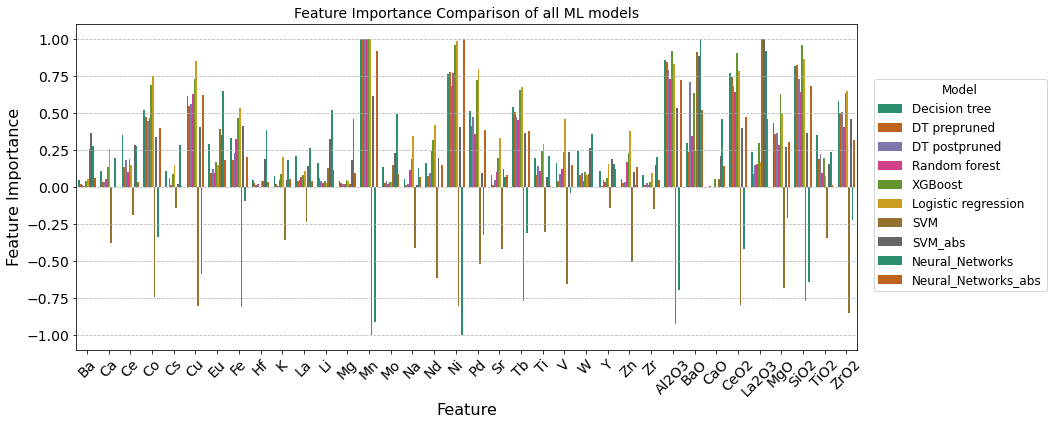

In [ ]:
# Melt the DataFrame to transform it into the suitable format for Plotly
df_melted = pd.melt(df_feature_importance, id_vars='Feature', var_name='Model', value_name='Importance')


# Set up the plot
plt.figure(figsize=(14, 6))

# Create a grouped bar plot
sns.barplot(x='Feature', y='Importance', hue='Model', data=df_melted, palette='Dark2')

# Customize the plot
plt.title('Feature Importance Comparison of all ML models', fontsize=14)
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Feature Importance', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Model', fontsize=12, title_fontsize=12, loc='upper right', bbox_to_anchor=(1.25, 0.85))

plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.savefig("/Users/parastoo/phd_projects/OCM/plots/Feature_Importance_Comparison_all_models.png", facecolor=(1,1,1,0), bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [ ]:
df_melted = pd.melt(df_feature_importance, id_vars='Feature', var_name='Model', value_name='Importance')

# Create a grouped bar plot using Plotly Express
fig = px.bar(df_melted, x='Feature', y='Importance', color='Model',
             labels={'Importance': 'Feature Importance', 'Model': 'Model'},
             title='Feature Importance Comparison',
             barmode='group'  # Set barmode to 'group' for grouped bars
            )  # Set the width of the bars

# Adjust the width of the bars in the layout
fig.update_layout(bargap=0.3, bargroupgap=0.3)


# Show the plot
fig.show()

In [ ]:
def custom_palette(arr):
    """Create a custom color palette based on the relevance scores."""
    min_val = min(arr)
    max_val = max(arr)
    n_colors = len(arr) * 2  # Increase the granularity of the palette

    # Generate a full 'coolwarm' palette
    full_palette = sns.color_palette("coolwarm", n_colors=n_colors)

    if min_val >= 0:  # Only positive values; use only the red part, reversed for darker shades at higher values
        return list(reversed(full_palette[len(arr):]))
    elif max_val <= 0:  # Only negative values; use only the blue part
        return full_palette[:len(arr)]
    else:
        num_negative = sum(x <= 0 for x in arr)
        num_positive = len(arr) - num_negative

        # Split the palette accordingly, but reverse the positive segment
        blue_part = int(num_negative / len(arr) * n_colors)
        red_part = n_colors - blue_part

        negative_palette = full_palette[:blue_part][:num_negative]
        positive_palette = list(reversed(full_palette[blue_part:][:num_positive]))

        return negative_palette + positive_palette


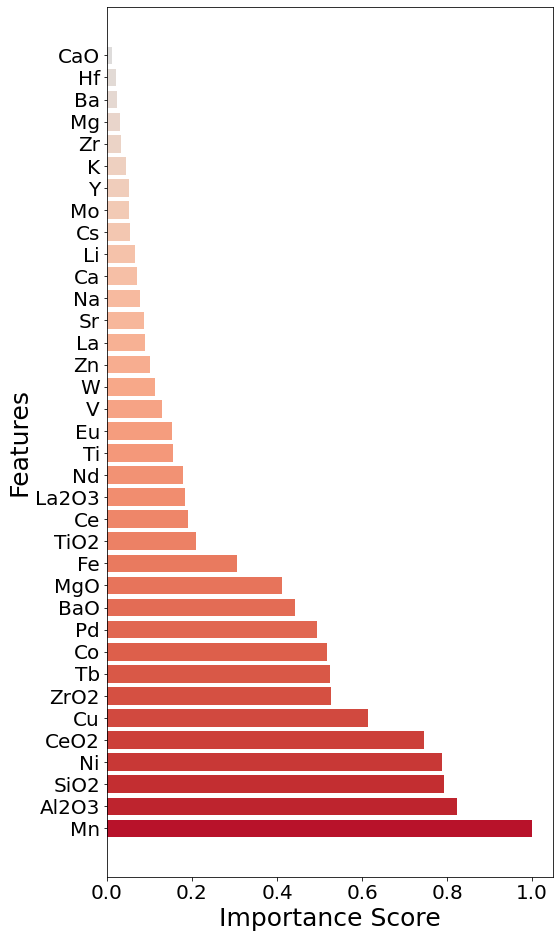

In [ ]:
df_feature_analysis = df_feature_importance.copy()

selected_tree_models = ['Decision tree', 'DT prepruned', 'DT postpruned', 'Random forest', 'XGBoost']

# Calculate the average importance for each feature across selected models
df_feature_analysis['AverageImportance_trees'] = df_feature_importance[selected_tree_models].mean(axis=1)

# Sort the DataFrame based on 'AverageImportance_trees' in descending order for plotting
df_sorted_selected = df_feature_analysis.sort_values(by='AverageImportance_trees', ascending=False)

# Use the custom palette for the colors
colors = custom_palette(df_sorted_selected['AverageImportance_trees'])

# Plotting for selected models
fig, ax = plt.subplots(figsize=(8, 16))
ax.barh(df_sorted_selected['Feature'], df_sorted_selected['AverageImportance_trees'], color=colors)

# Set labels and title for selected models
ax.set_xlabel('Importance Score', fontsize=25)
ax.set_ylabel('Features', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("/Users/parastoo/phd_projects/OCM/plots/Average_Feature_Importance_trees_Models.png", dpi=300)

# Show the plot
plt.show()


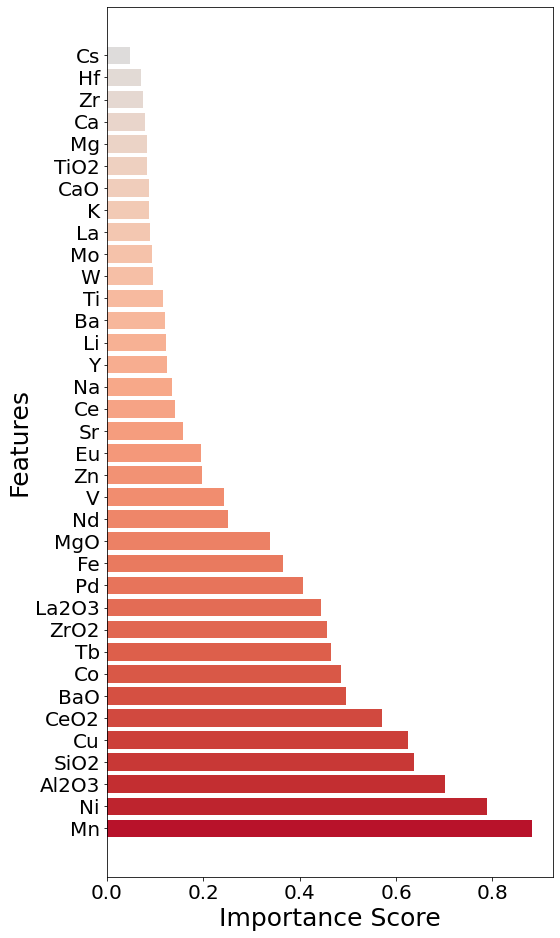

In [ ]:
df_feature_analysis = df_feature_importance.copy()

selected_models = ['Random forest', 'Logistic regression', 'SVM_abs', 'Neural_Networks_abs']

# Calculate the average importance for each feature across selected models
df_feature_analysis['AverageImportance_selected'] = df_feature_importance[selected_models].mean(axis=1)

# Sort the DataFrame based on 'AverageImportance_trees' in descending order for plotting
df_sorted_selected = df_feature_analysis.sort_values(by='AverageImportance_selected', ascending=False)

# Use the custom palette for the colors
colors = custom_palette(df_sorted_selected['AverageImportance_selected'])

# Plotting for selected models
fig, ax = plt.subplots(figsize=(8, 16))
ax.barh(df_sorted_selected['Feature'], df_sorted_selected['AverageImportance_selected'], color=colors)

# Set labels and title for selected models
ax.set_xlabel('Importance Score', fontsize=25)
ax.set_ylabel('Features', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("/Users/parastoo/phd_projects/OCM/plots/Average_Feature_Importance_selected_Models.png", dpi=300)

# Show the plot
plt.show()


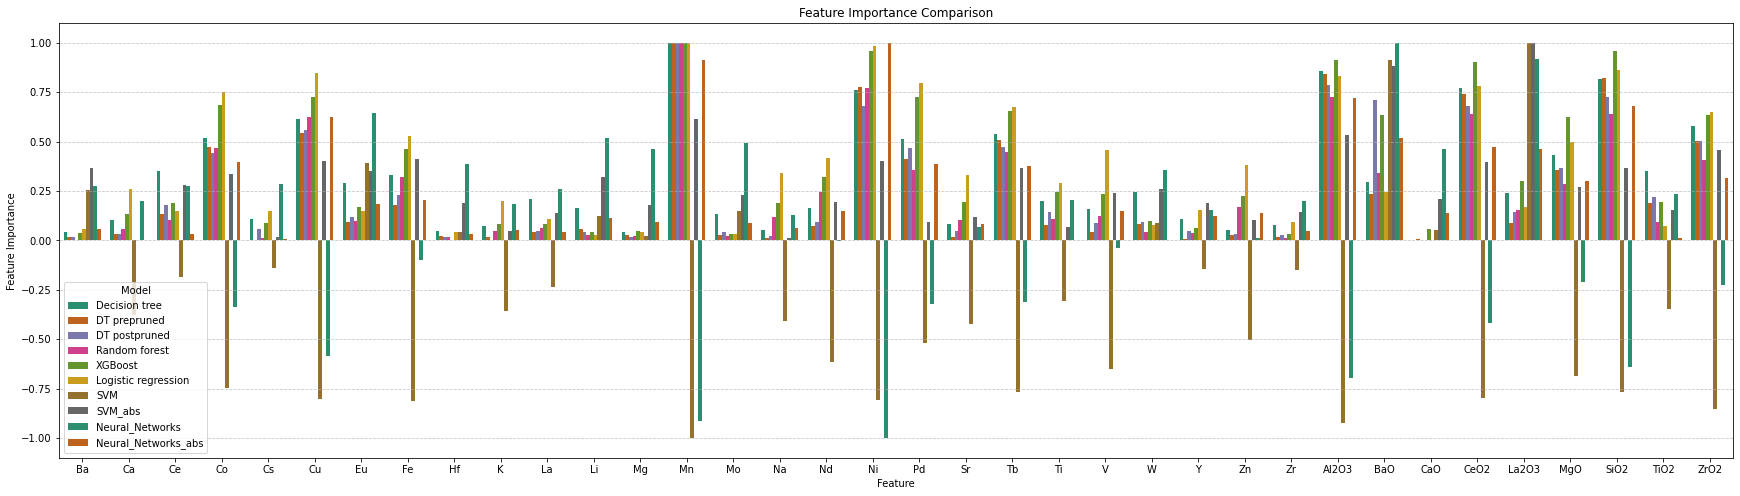

In [ ]:
df_melted = pd.melt(df_feature_importance, id_vars='Feature', var_name='Model', value_name='Importance')

# Set up the plot
plt.figure(figsize=(30, 8))

# Create a grouped bar plot
sns.barplot(x='Feature', y='Importance', hue='Model', data=df_melted, palette='Dark2')

# Customize the plot
plt.title('Feature Importance Comparison')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

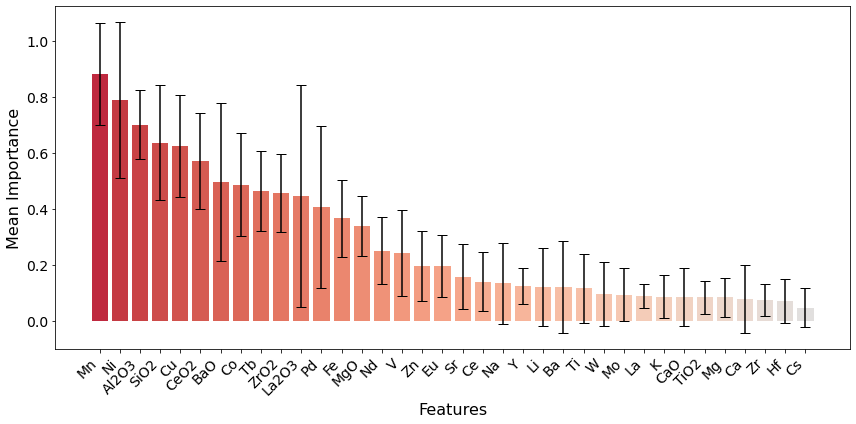

In [ ]:
model_columns = ['Random forest', 'Logistic regression', 'SVM_abs', 'Neural_Networks_abs']
df_models_only = df_feature_importance[model_columns]
# Calculate mean and standard deviation along each row
mean_values = df_models_only.mean(axis=1)
std_values = df_models_only.std(axis=1)

# Create a DataFrame to combine features, their mean importances, and standard deviations
importances = pd.DataFrame({'Feature': df_feature_importance['Feature'], 'MeanImportance': mean_values.values, 'StdDev': std_values.values})

# Sort the DataFrame based on 'MeanImportance' in descending order
importances_sorted = importances.sort_values(by='MeanImportance', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
colors = custom_palette(importances['MeanImportance'])

# Create a bar plot with error bars using sorted data
# Note: The index of importances_sorted is used directly; this ensures matching between features and their values
ax.bar(importances_sorted['Feature'], importances_sorted['MeanImportance'], yerr=importances_sorted['StdDev'], capsize=5, color=colors, alpha=0.9)

# Set labels and title
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Mean Importance', fontsize=16)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(0, 0.16)

plt.tight_layout()
plt.savefig("/Users/parastoo/phd_projects/OCM/plots/Mean_Feature_Importance_with_Error_Bars_selected_horizontal.png", dpi=300, facecolor=(1,1,1,0), bbox_inches='tight')
plt.show()


## Fisher Z

In [ ]:
model_columns = [col for col in df_feature_importance.columns if col not in ['Feature']]
model_columns

['Decision tree',
 'DT prepruned',
 'DT postpruned',
 'Random forest',
 'XGBoost',
 'Logistic regression',
 'SVM',
 'SVM_abs',
 'Neural_Networks',
 'Neural_Networks_abs']

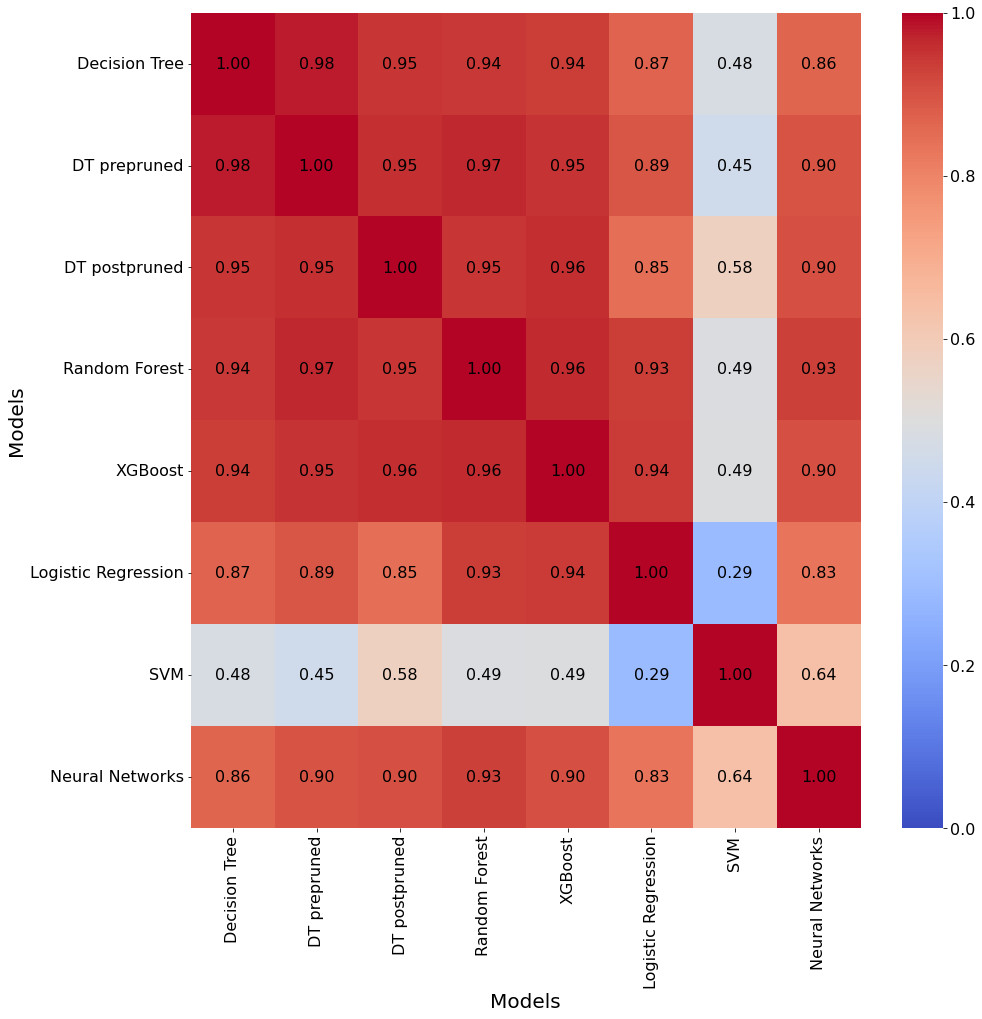

In [ ]:
#model_columns = [col for col in df_feature_importance.columns if col not in ['Feature']]
model_columns = ['Decision tree', 'DT prepruned', 'DT postpruned', 'Random forest', 'XGBoost', 'Logistic regression', 'SVM_abs', 'Neural_Networks_abs']
df_models_only = df_feature_importance[model_columns]

# Calculate Pearson correlation coefficients for model columns only
correlation_matrix = df_models_only.corr()

# Apply Fisher Z transformation
def fisher_z_transform(r):
    if r == 1:
        return np.inf
    elif r == -1:
        return -np.inf
    else:
        return np.log((1 + r) / (1 - r)) / 2
        
def inverse_fisher_z_transform(z):
    if z == np.inf:
        return 1.0
    elif z == -np.inf:
        return -1.0
    else:
        return (np.exp(2*z) - 1) / (np.exp(2*z) + 1)

# Fill diagonal with zeros to avoid division by zero
np.fill_diagonal(correlation_matrix.values, 0)

# Calculate mean of transformed values for each model pair
average_correlation_coefficients = {}
for model1 in correlation_matrix.index:
    for model2 in correlation_matrix.index:
        if model1 != model2:
            correlation_value = correlation_matrix.loc[model1, model2]
            correlation_value_transformed = fisher_z_transform(correlation_value)
            average_correlation_coefficients[(model1, model2)] = inverse_fisher_z_transform(correlation_value_transformed)


# Create a matrix representation
matrix_size = len(model_columns)
correlation_matrix_matrix = np.zeros((matrix_size, matrix_size))

for i, model1 in enumerate(model_columns):
    for j, model2 in enumerate(model_columns):
        if i != j:
            correlation_matrix_matrix[i, j] = average_correlation_coefficients[(model1, model2)]

np.fill_diagonal(correlation_matrix_matrix, 1)
# Create a heatmap

plt.figure(figsize=(15, 15))
ticks= ['Decision Tree','DT prepruned', 'DT postpruned', 'Random Forest', 'XGBoost', 'Logistic Regression', 'SVM', 'Neural Networks']
heatmap = sns.heatmap(correlation_matrix_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=ticks, yticklabels=ticks, annot_kws={"size": 16, "color":'black'}, vmin=0)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
# plt.xticks(rotation=90, fontsize=14)
# plt.yticks(rotation=0, fontsize=14)
plt.xlabel("Models", fontsize=20)
plt.ylabel("Models", fontsize=20)
plt.xlabel("Models")
plt.ylabel("Models")

# Get the colorbar object
cbar = heatmap.collections[0].colorbar

# Set the font size of colorbar tick labels
cbar.ax.tick_params(labelsize=16)

plt.savefig("/Users/parastoo/phd_projects/OCM/plots/Average_corr_coeff_for_all_models.png", facecolor=(1,1,1,0), bbox_inches='tight', dpi=300)
plt.show()



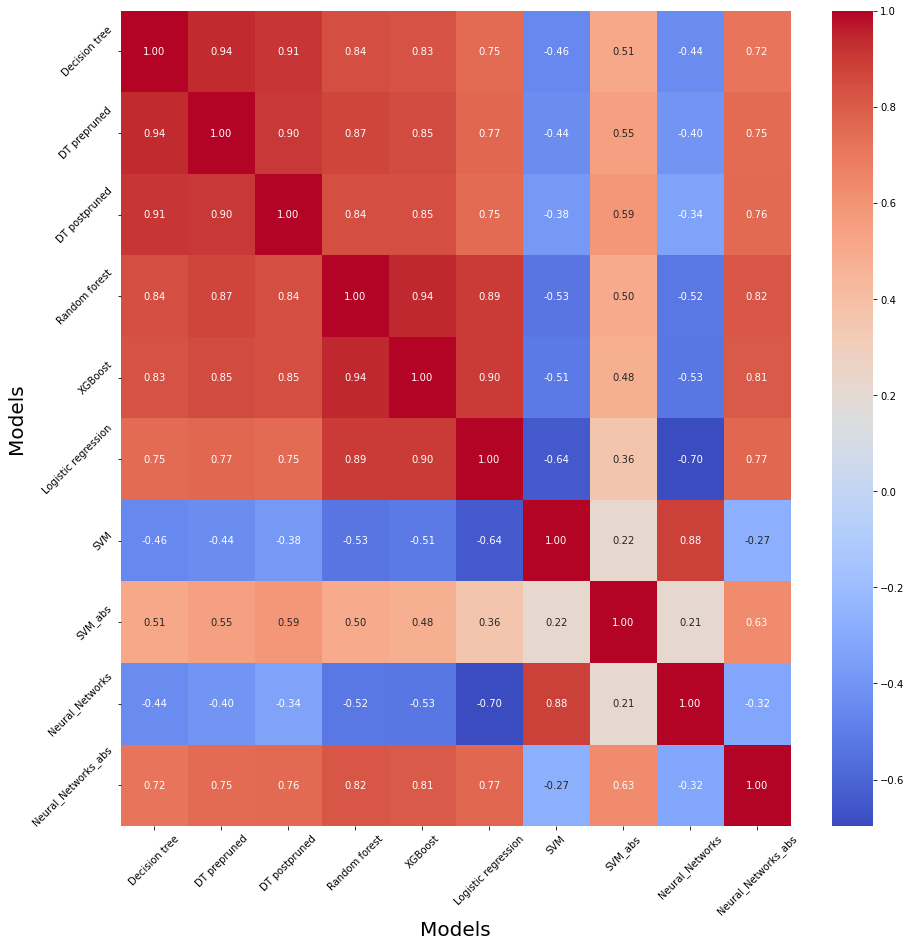

In [ ]:
from scipy.stats import weightedtau

model_columns = [col for col in df_feature_importance.columns if col not in ['Feature']]
df_models_only = df_feature_importance[model_columns]

# Function to calculate weighted tau for a pair of series
def calc_weighted_tau(series1, series2):
    correlation, _ = weightedtau(series1, series2, rank=True)
    return correlation

# Create an empty DataFrame for storing weighted tau values
weighted_tau_matrix = pd.DataFrame(index=model_columns, columns=model_columns)

# Calculate weighted tau for each pair of models
for model1 in model_columns:
    for model2 in model_columns:
        if model1 != model2:
            weighted_tau_matrix.loc[model1, model2] = calc_weighted_tau(df_models_only[model1], df_models_only[model2])
        else:
            weighted_tau_matrix.loc[model1, model2] = np.nan  # Set diagonal to NaN

# Convert the weighted tau matrix to numeric values (it might contain strings due to NaN assignments)
weighted_tau_matrix = weighted_tau_matrix.apply(pd.to_numeric)

# Fill diagonal with zeros for visual clarity in the heatmap
np.fill_diagonal(weighted_tau_matrix.values, 1)

# Create a heatmap
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(weighted_tau_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=model_columns, yticklabels=model_columns)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.xlabel("Models", fontsize = 20)
plt.ylabel("Models", fontsize = 20)

# Get the colorbar object and set the font size of colorbar tick labels
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.show()


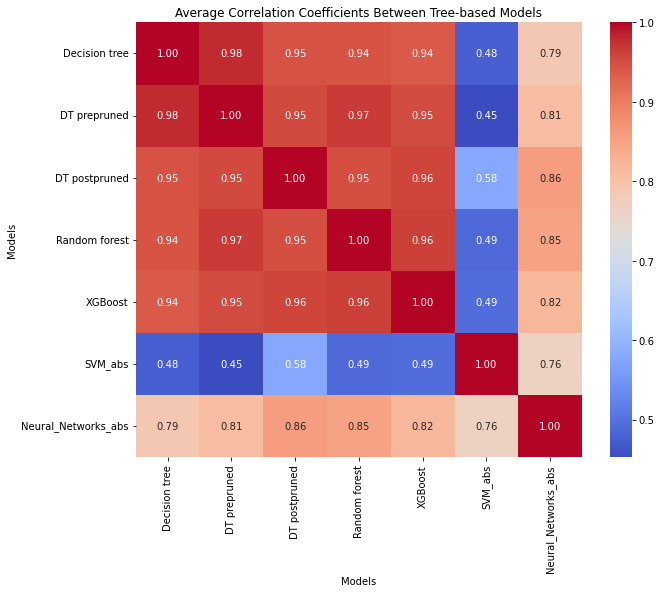

In [ ]:
selected_models = ['Decision tree', 'DT prepruned', 'DT postpruned', 'Random forest',
       'XGBoost', 'SVM_abs', 'Neural_Networks_abs']  # Replace with the names of the models you want to select

# Filter DataFrame to keep only the selected models
selected_df = df_feature_importance[selected_models]

# Calculate Pearson correlation coefficients
correlation_matrix = selected_df.corr()

# Apply Fisher Z transformation
def fisher_z_transform(r):
    if r == 1:
        return np.inf
    elif r == -1:
        return -np.inf
    else:
        return np.log((1 + r) / (1 - r)) / 2

# Fill diagonal with zeros to avoid division by zero
np.fill_diagonal(correlation_matrix.values, 0)

# Calculate mean of transformed values for each model pair
average_correlation_coefficients = {}
for model1 in correlation_matrix.index:
    for model2 in correlation_matrix.index:
        if model1 != model2:
            correlation_value = correlation_matrix.loc[model1, model2]
            correlation_value_transformed = fisher_z_transform(correlation_value)
            average_correlation_coefficients[(model1, model2)] = inverse_fisher_z_transform(correlation_value_transformed)

# Create a matrix representation
matrix_size = len(selected_models)
correlation_matrix_matrix = np.zeros((matrix_size, matrix_size))

for i, model1 in enumerate(selected_models):
    for j, model2 in enumerate(selected_models):
        if i != j:
            correlation_matrix_matrix[i, j] = average_correlation_coefficients[(model1, model2)]


np.fill_diagonal(correlation_matrix_matrix, 1)
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=selected_models, yticklabels=selected_models)
plt.title("Average Correlation Coefficients Between Tree-based Models")
plt.xlabel("Models")
plt.ylabel("Models")
plt.savefig("/Users/parastoo/phd_projects/OCM/Figures/Average_Correlation_Coefficients_Between_Tree-based_Models_new.png", facecolor=(1,1,1,0), bbox_inches='tight', dpi=300)
plt.show()


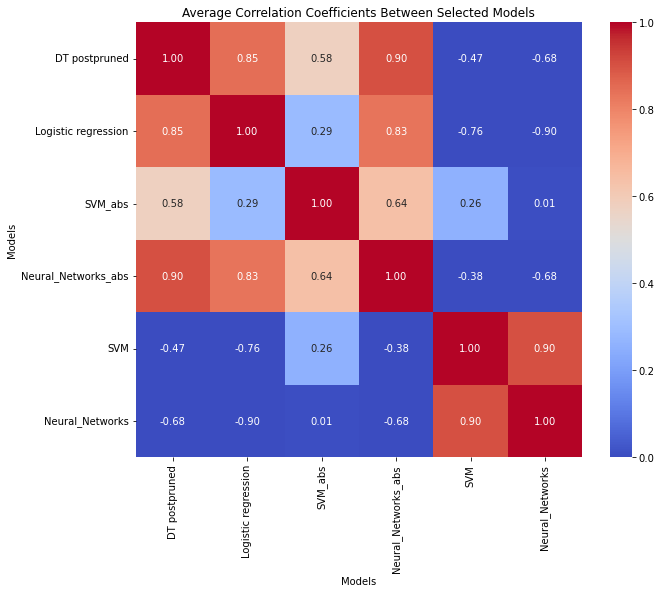

In [ ]:
selected_models = ['DT postpruned','Logistic regression','SVM_abs', 'Neural_Networks_abs', 'SVM', 'Neural_Networks']  # Replace with the names of the models you want to select

# Filter DataFrame to keep only the selected models
selected_df = df_feature_importance[selected_models]

# Calculate Pearson correlation coefficients
correlation_matrix = selected_df.corr()

# Apply Fisher Z transformation
def fisher_z_transform(r):
    if r == 1:
        return np.inf
    elif r == -1:
        return -np.inf
    else:
        return np.log((1 + r) / (1 - r)) / 2

# Fill diagonal with zeros to avoid division by zero
np.fill_diagonal(correlation_matrix.values, 0)

# Calculate mean of transformed values for each model pair
average_correlation_coefficients = {}
for model1 in correlation_matrix.index:
    for model2 in correlation_matrix.index:
        if model1 != model2:
            correlation_value = correlation_matrix.loc[model1, model2]
            correlation_value_transformed = fisher_z_transform(correlation_value)
            average_correlation_coefficients[(model1, model2)] = inverse_fisher_z_transform(correlation_value_transformed)

# Create a matrix representation
matrix_size = len(selected_models)
correlation_matrix_matrix = np.zeros((matrix_size, matrix_size))

for i, model1 in enumerate(selected_models):
    for j, model2 in enumerate(selected_models):
        if i != j:
            correlation_matrix_matrix[i, j] = average_correlation_coefficients[(model1, model2)]
np.fill_diagonal(correlation_matrix_matrix, 1)
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=selected_models, yticklabels=selected_models, vmin=0, vmax=1)
plt.title("Average Correlation Coefficients Between Selected Models")
plt.xlabel("Models")
plt.ylabel("Models")
plt.savefig("/Users/parastoo/phd_projects/OCM/Figures/Average_Correlation_Coefficients_Between_one_tree_and_others_new.png", facecolor=(1,1,1,0), bbox_inches='tight', dpi=300)
plt.show()


## DONE